# Face Recognition

Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import re
import math
from mpl_toolkits.axes_grid1 import ImageGrid
from PIL import Image
from pathlib import Path
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import LabelEncoder

np.set_printoptions(precision=4)
plt.rcParams['figure.figsize'] = [10, 6]

%load_ext autotime

time: 0 ns (started: 2023-03-22 22:04:20 +02:00)


## 1. Download the Dataset and Understand the Format

a. ORL dataset is available at the following link.

https://www.kaggle.com/kasikrit/att-database-of-faces/

b. The dataset has 10 images per 40 subjects. Every image is a grayscale image of size 92x112.

## 2. Generate the Data Matrix and the Label vector

a. Convert every image into a vector of 10304 values corresponding to the
image size.

b. Stack the 400 vectors into a single Data Matrix D and generate the label
vector y. The labels are integers from 1:40 corresponding to the subject
id.

In [ ]:
D = np.empty((400, 10304))
y = np.empty((400, 1))
D_non = np.empty((400, 10304))
y_non = np.empty((400, 1))
D_mixed = np.empty((800, 10304))
y_mixed = np.empty((800, 1))
y1 = np.empty((400, 1))
y2 = np.empty((400, 1))

In [3]:
def read_pgm(filename, byteorder='>'):
    """Return image data from a raw PGM file as numpy array.
    Format specification: http://netpbm.sourceforge.net/doc/pgm.html
    """
    with open(filename, 'rb') as f:
        buffer = f.read()
    try:
        header, width, height, maxval = re.search(
            b"(^P5\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n])*"
            b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    except AttributeError:
        raise ValueError("Not a raw PGM file: '%s'" % filename)
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

time: 0 ns (started: 2023-03-22 22:04:20 +02:00)


In [4]:
def read_img(file_path,D,y):
    i = 0
    for folder, _, files in os.walk(file_path):
        for f in files:
            if (f.split('.')[-1] == 'pgm'):
                D[i] = read_pgm(f"{folder}\\{f}", byteorder='<').reshape(-1)
                y[i] = folder.split("\\")[-1][1:]
                i += 1
            elif(f.split('.')[-1] == 'jpg'):    
                img = cv2.imread(f"{folder}\\{f}")
                img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                D[i] = (cv2.resize(img_gray,(112,92))).reshape(-1)
                y[i] = folder.split("\\")[-1][1:]
                i += 1
    return D, y

time: 0 ns (started: 2023-03-22 22:04:20 +02:00)


Constructing faces dataset

In [5]:
D, y = read_img("att_faces", D, y)

time: 3.78 s (started: 2023-03-22 22:04:20 +02:00)


In [6]:
D = D.astype('uint8')
y = y.astype('uint8')

time: 16 ms (started: 2023-03-22 22:04:24 +02:00)


**Displaying the images**

In [7]:
def display_images(D, width, height):
    fig = plt.figure(figsize=(32, 32))
    grid = ImageGrid(fig, 111, nrows_ncols=(40, 10), axes_pad=0.05)
    images = [img.reshape((width, height)) for img in D]
    for ax, im in zip(grid, images):
        ax.imshow(im, cmap='gray')
        ax.axis('off')
    plt.show()

time: 0 ns (started: 2023-03-22 22:04:24 +02:00)


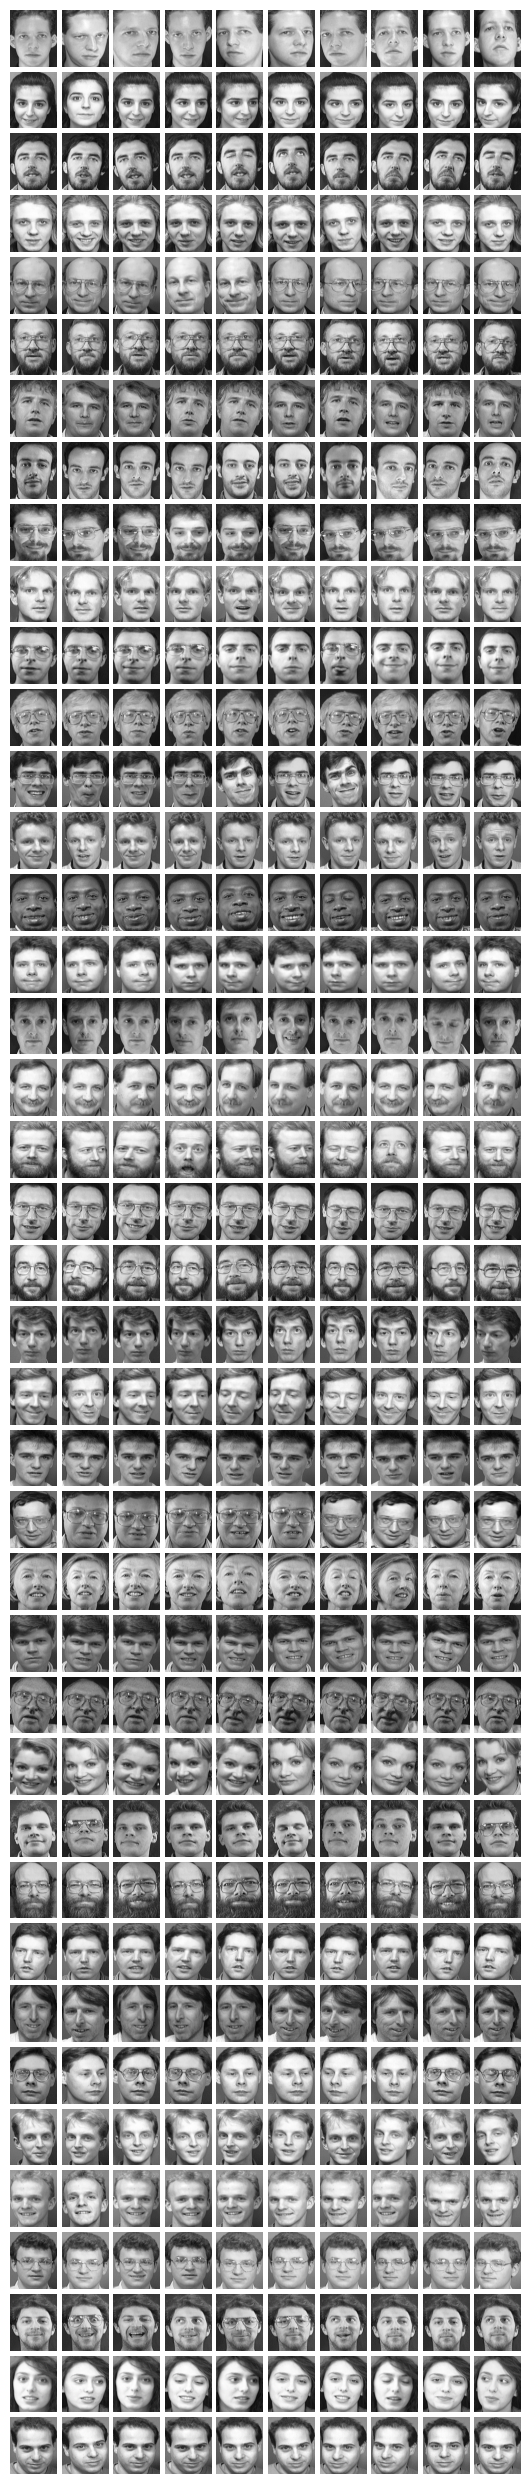

time: 49.9 s (started: 2023-03-22 22:04:24 +02:00)


In [8]:
display_images(D,112,92)

## 3. Split the Dataset into Training and Test sets

a. From the Data Matrix D400x10304 keep the odd rows for training and
the even rows for testing. This will give you 5 instances per person for
training and 5 instances per person for testing.

b. Split the labels vector accordingly.

In [9]:
x_train = D[1::2]
x_test = D[0::2]
y_train = y[1::2]
y_test = y[0::2]

time: 0 ns (started: 2023-03-22 22:05:14 +02:00)


In [10]:
x_train.shape

(200, 10304)

time: 0 ns (started: 2023-03-22 22:05:14 +02:00)


In [11]:
x_test.shape

(200, 10304)

time: 0 ns (started: 2023-03-22 22:05:14 +02:00)


In [12]:
y_train.shape

(200, 1)

time: 0 ns (started: 2023-03-22 22:05:14 +02:00)


In [13]:
y_test.shape

(200, 1)

time: 0 ns (started: 2023-03-22 22:05:14 +02:00)


## 4. Classification using PCA

a. Use the pseudo code below for computing the projection matrix U.
Define the alpha = {0.8, 0.85, 0.9, 0.95}

b. Project the training set, and test sets separately using the same
projection matrix.

c. Use a simple classifier (first Nearest Neighbor to determine the class
labels).

d. Report Accuracy for every value of alpha separately.

e. Can you find a relation between alpha and classification accuracy?

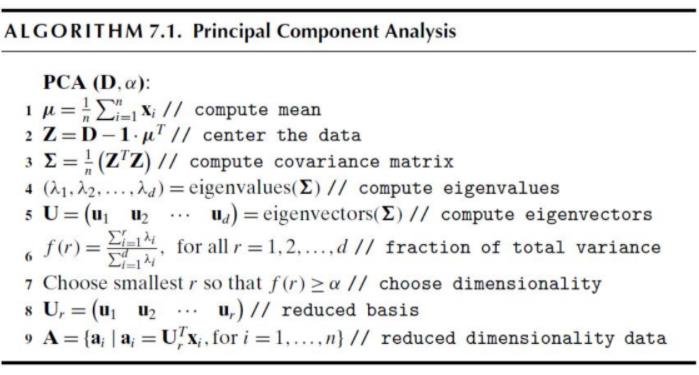

**Auxiliary Functions**

In [14]:
def project(x, U):
    return np.dot(U.T, x.T).T

time: 0 ns (started: 2023-03-22 22:05:14 +02:00)


In [15]:
def knn_classifier(a, neighbor, x_train, y_train, x_test, y_test, flag, acc_scores_list):
    knn = KNeighborsClassifier(n_neighbors=neighbor)
    knn.fit(x_train, np.ravel(y_train))
    prediction = knn.predict(x_test)
    acc_score = accuracy_score(y_test, prediction)
    if flag == "PCA":
        acc_scores_list.append(acc_score)
        print(f"@ α = {np.round(a, decimals=2)}:\taccuracy score = {acc_score*100}%")
    elif flag== "LDA":
        acc_scores_list.append(acc_score)
        print(f"@ n_neighbor = {neighbor}:\taccuracy score = {acc_score*100}%")
    return prediction     

time: 0 ns (started: 2023-03-22 22:05:14 +02:00)


**Pseudocode**

In [16]:
def extract_eigs(D):
    # Compute mean
    mean = np.mean(D, axis=0)
    
    # Center the data
    Z = D - mean
    
    # Compute covariance matrix
    cov_matrix = np.cov(Z.T, bias=True)
    
    # Compute eigenvectors and eigenvalues
    lambdas, U = np.linalg.eigh(cov_matrix)
    lambdas = lambdas[::-1]
    U = U[:,::-1]
    
    return lambdas, U

time: 0 ns (started: 2023-03-22 22:05:14 +02:00)


In [17]:
def PCA(D, lambdas, U, alpha):
    # Fraction of total variance
    total_lambdas = np.sum(lambdas)
    
    # Choose dimensionality
    i = 0
    f_r = 0
    while f_r < alpha:
        f_r = np.sum(lambdas[:i+1]) / total_lambdas
        i+=1
    
    # Reduced basis
    U_reduced = U[:, :i-1]
    A = project(D - np.mean(D, axis=0), U_reduced)
    
    return A

time: 0 ns (started: 2023-03-22 22:05:14 +02:00)


In [18]:
lambdas, U = extract_eigs(x_train)

time: 16min 5s (started: 2023-03-22 22:05:14 +02:00)


In [66]:
alpha = np.arange(0.3, 1.05, 0.05)
results = dict()
acc_scores_list = []
for a in alpha:
    results[a] = dict()
    results[a]['A_train'] = PCA(x_train, lambdas, U, a)
    results[a]['A_test'] = PCA(x_test, lambdas, U, a)

    knn_classifier(a, 1, results[a]['A_train'], y_train, results[a]['A_test'], y_test, "PCA", acc_scores_list)

@ α = 0.3:	accuracy score = 8.5%
@ α = 0.35:	accuracy score = 37.5%
@ α = 0.4:	accuracy score = 69.0%
@ α = 0.45:	accuracy score = 74.5%
@ α = 0.5:	accuracy score = 77.5%
@ α = 0.55:	accuracy score = 90.5%
@ α = 0.6:	accuracy score = 88.0%
@ α = 0.65:	accuracy score = 91.0%
@ α = 0.7:	accuracy score = 92.0%
@ α = 0.75:	accuracy score = 93.0%
@ α = 0.8:	accuracy score = 93.5%
@ α = 0.85:	accuracy score = 94.0%
@ α = 0.9:	accuracy score = 93.5%
@ α = 0.95:	accuracy score = 93.5%
@ α = 1.0:	accuracy score = 94.5%
time: 2.39 s (started: 2023-03-23 00:49:01 +02:00)


Text(0, 0.5, 'Accuracy Score')

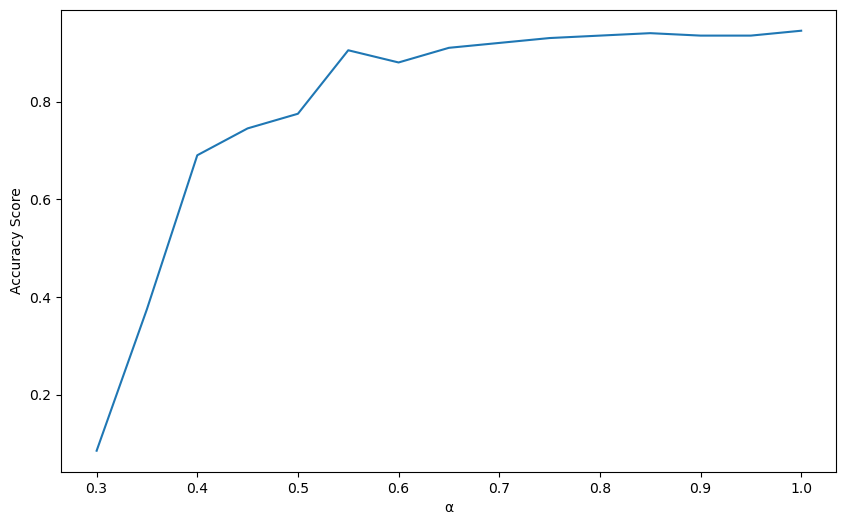

time: 344 ms (started: 2023-03-23 00:49:03 +02:00)


In [67]:
plt.plot(alpha, acc_scores_list)
plt.xlabel("α")
plt.ylabel("Accuracy Score")

## 5. Classification using LDA

a. Use the pseudo code below for LDA. We will modify few lines in
pseudocode to handle multiclass LDA.

> i. Calculate the mean vector for every class Mu1, Mu2, ..., Mu40.

> ii. Replace $B$ matrix by $S_b$. 

>> $S_b = \sum_{k=1}^{m} n_k(𝜇_k - 𝜇)(𝜇_k - 𝜇)^T$

> Here, m is the number of classes, 𝜇 is the overall sample mean, and 𝑛𝑘 is the number of samples in the k-th class.

> iii. S matrix remains the same, but it sums S1, S2, S3, ...S40.

> iv. Use 39 dominant eigenvectors instead of just one. You will
have a projection matrix U39x10304.

b. Project the training set, and test sets separately using the same projection matrix U. You will have 39 dimensions in the new space.

c. Use a simple classifier (first Nearest Neighbor to determine the class labels).

d. Report accuracy for the multiclass LDA on the face recognition dataset.

e. Compare the results to PCA results.

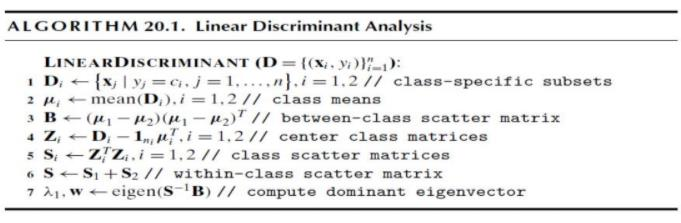

**Auxiliary Functions**

In [21]:
def class_label_encoding(y):
    class_labels = np.ravel(y)
    enc = LabelEncoder()
    label_encoder = enc.fit(class_labels)
    class_labels = label_encoder.transform(class_labels) + 1
    return class_labels

time: 16 ms (started: 2023-03-22 22:21:24 +02:00)


In [22]:
def compute_mean_per_class(Di, mean_vectors):
    mean_class = np.mean(Di, axis=0)
    mean_vectors.append(mean_class)
    return mean_class, mean_vectors

time: 16 ms (started: 2023-03-22 22:21:24 +02:00)


In [23]:
def within_scatter_matrix(SW, n_features, Di, mean_class):
    SW += (Di - mean_class).T.dot((Di - mean_class))
    return SW

time: 0 ns (started: 2023-03-22 22:21:24 +02:00)


In [24]:
def between_class_scatter_matrix(SB, n_c, n_features, mean_class, mean_data):
    mean_diff = (mean_class - mean_data).reshape(n_features, 1)
    SB += n_c * (mean_diff).dot(mean_diff.T)
    return SB

time: 0 ns (started: 2023-03-22 22:21:24 +02:00)


In [25]:
def extract_eigVal_eigVec(SW, SB, n_features):
    A = np.linalg.inv(SW).dot(SB)
    eigenvalues, eigenvectors = np.linalg.eigh(A)
    return eigenvalues, eigenvectors

time: 0 ns (started: 2023-03-22 22:21:24 +02:00)


In [26]:
def sort_eigenVec(eigenvalues, eigenvectors,n_features,components):
    eig_pairs = [(np.abs(eigenvalues[i]), eigenvectors[:,i]) for i in range(len(eigenvalues))]
    eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)
    U = np.hstack([eig_pairs[i][1].reshape(n_features, 1) for i in range(0, components)])
    return U

time: 0 ns (started: 2023-03-22 22:21:24 +02:00)


**Pseudocode**

In [27]:
def LDA(D, y, n_eigenvectors):
    class_labels = class_label_encoding(y)
    
    # Allocations
    mean_vectors = []
    n_features = D.shape[1]
    mean_data = np.mean(D, axis=0)
    SW = np.zeros((n_features, n_features))
    SB = np.zeros((n_features, n_features))
    
    for cl in np.unique(class_labels):
        # Class-specific subsets
        Di = D[class_labels==cl]
        n_c = Di.shape[0]
      
        # Class means
        mean_class, mean_vectors = compute_mean_per_class(Di, mean_vectors)
      
        # Within-class scatter matrices
        SW = within_scatter_matrix(SW, n_features, Di, mean_class)
      
        # Between-class scatter matrix
        SB = between_class_scatter_matrix(SB, n_c, n_features, mean_class, mean_data)
      
        #print('Mean Vector class %s: %s\n' %(cl, mean_vectors[cl-1]))
    
    #print('Within-class scatter matrices:\n%s\n' %(SW))
    #print('between-class scatter matrices:\n%s' %(SB))
    
    # Computer dominant eigenvector
    eigenvalues, eigenvectors = extract_eigVal_eigVec(SW, SB, n_features)
    U = sort_eigenVec(eigenvalues, eigenvectors, n_features, components=n_eigenvectors)
    return U

time: 16 ms (started: 2023-03-22 22:21:24 +02:00)


In [28]:
U_lda = LDA(x_train, y_train, 39)

time: 20min 57s (started: 2023-03-22 22:21:24 +02:00)


In [29]:
U_lda.shape

(10304, 39)

time: 31 ms (started: 2023-03-22 22:42:22 +02:00)


In [30]:
lda_train = x_train.dot(U_lda)
lda_test = x_test.dot(U_lda)
acc_list = []
pre = knn_classifier(None, 1, lda_train, y_train, lda_test, y_test, "LDA", acc_list)

@ n_neighbor = 1:	accuracy score = 94.5%
time: 422 ms (started: 2023-03-22 22:42:22 +02:00)


## 6. Classifier Tuning

a. Set the number of neighbors in the K-NN classifier to 1, 3, 5, 7.

b. Tie breaking at your preferred strategy.

c. Plot (or tabulate) the performance measure (accuracy) against the
K value. This is to be done for PCA and LDA as well.

### PCA

@ α = 0.8:	accuracy score = 93.5%
@ α = 0.8:	accuracy score = 82.0%
@ α = 0.8:	accuracy score = 80.0%
@ α = 0.8:	accuracy score = 77.0%
@ α = 0.85:	accuracy score = 94.0%
@ α = 0.85:	accuracy score = 84.5%
@ α = 0.85:	accuracy score = 80.0%
@ α = 0.85:	accuracy score = 76.5%
@ α = 0.9:	accuracy score = 93.5%
@ α = 0.9:	accuracy score = 84.5%
@ α = 0.9:	accuracy score = 79.0%
@ α = 0.9:	accuracy score = 75.5%
@ α = 0.95:	accuracy score = 93.5%
@ α = 0.95:	accuracy score = 84.0%
@ α = 0.95:	accuracy score = 79.0%
@ α = 0.95:	accuracy score = 75.5%


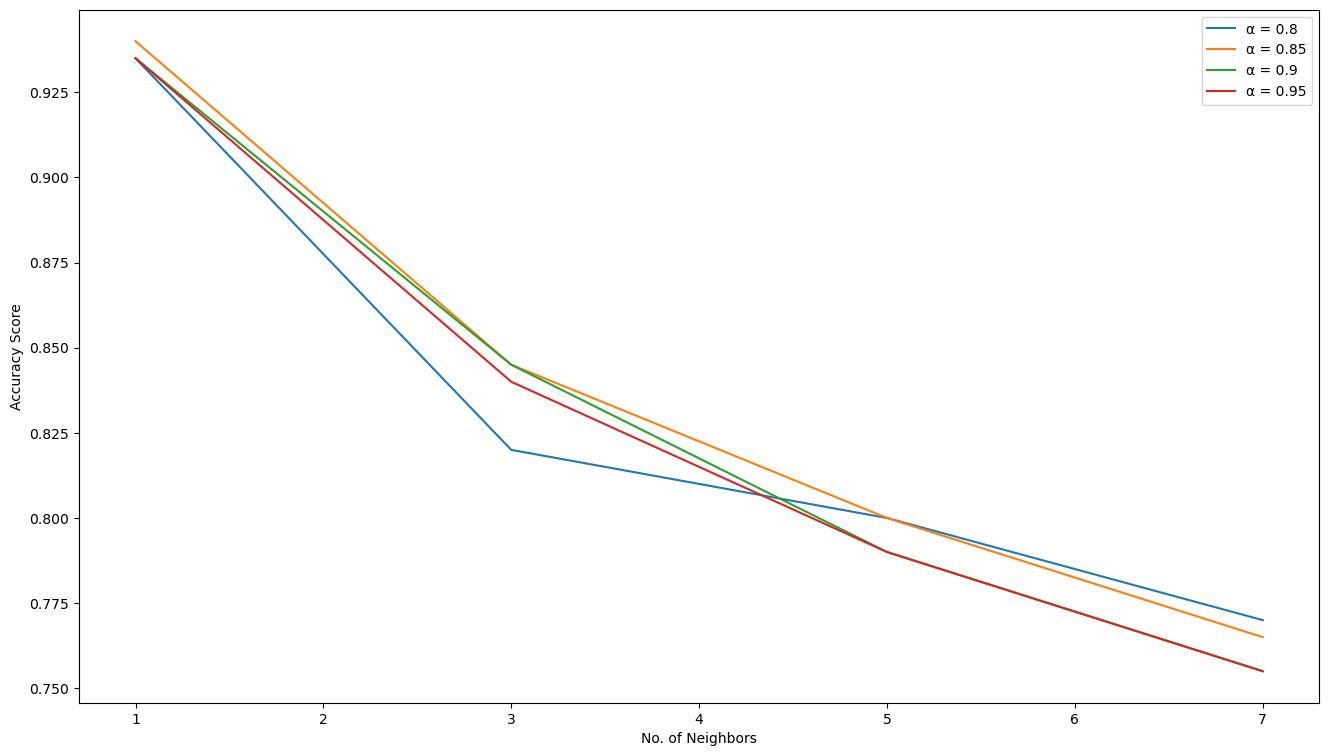

time: 4.31 s (started: 2023-03-22 22:42:22 +02:00)


In [31]:
plt.figure(figsize=(16,9))

nn_list = [1, 3, 5, 7]
for a in alpha[-5:-1]:
    k_acc_scores_list = []
    for nn in nn_list:
        knn_classifier(a, nn, results[a]['A_train'], y_train, results[a]['A_test'], y_test, "PCA", k_acc_scores_list)
    plt.plot(nn_list, k_acc_scores_list, label=a)
plt.legend([f'α = {np.round(a, decimals=2)}' for a in alpha[-5:-1]])
plt.xlabel("No. of Neighbors")
plt.ylabel("Accuracy Score")
plt.show()

### LDA

@ n_neighbor = 1:	accuracy score = 94.5%
@ n_neighbor = 3:	accuracy score = 85.0%
@ n_neighbor = 5:	accuracy score = 79.0%
@ n_neighbor = 7:	accuracy score = 73.0%


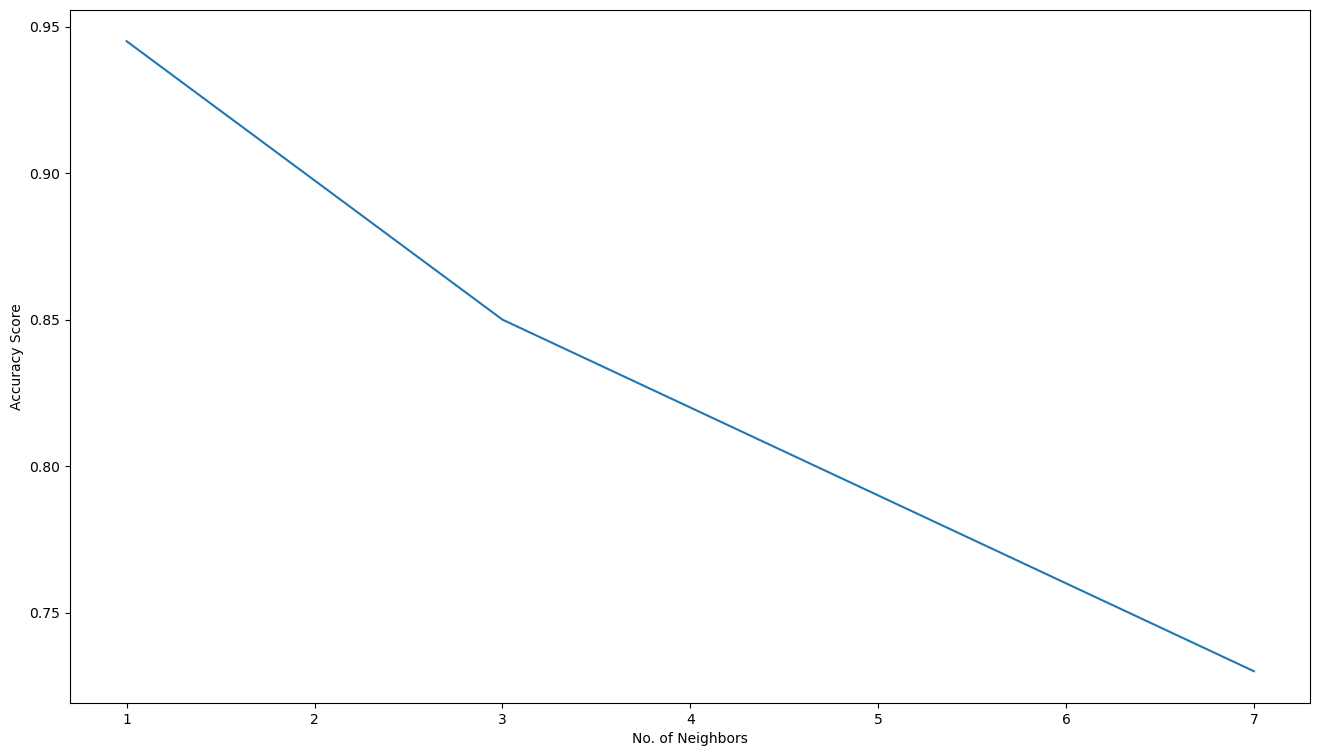

time: 1.47 s (started: 2023-03-22 22:42:26 +02:00)


In [32]:
plt.figure(figsize=(16,9))
accuracy = []
nn_list = [1, 3, 5, 7]
for nn in nn_list:
    knn_classifier(None, nn, lda_train, y_train, lda_test, y_test, "LDA", accuracy)
plt.plot(nn_list, accuracy)
plt.xlabel("No. of Neighbors")
plt.ylabel("Accuracy Score")
plt.show()

## 7. Compare vs Non-Face Images

a. Download non-face images and make them of the same size 92x112.
and try to solve the classification problem faces vs. Non-faces.

> i. Show failure and success cases.

> ii. How many dominant eigenvectors will you use for the LDA
solution?

> iii. Plot the accuracy vs the number of non-faces images while fixing
the number of face images.

> iv. Criticize the accuracy measure for large numbers of non-faces
images in the training data.

**Constructing non-faces dataset**

In [33]:
D_non, y_non = read_img("non_faces", D_non, y_non)
D_non = D_non.astype('uint8')
y_non = y_non.astype('uint8')

time: 8.17 s (started: 2023-03-22 22:42:28 +02:00)


**Displaying images**

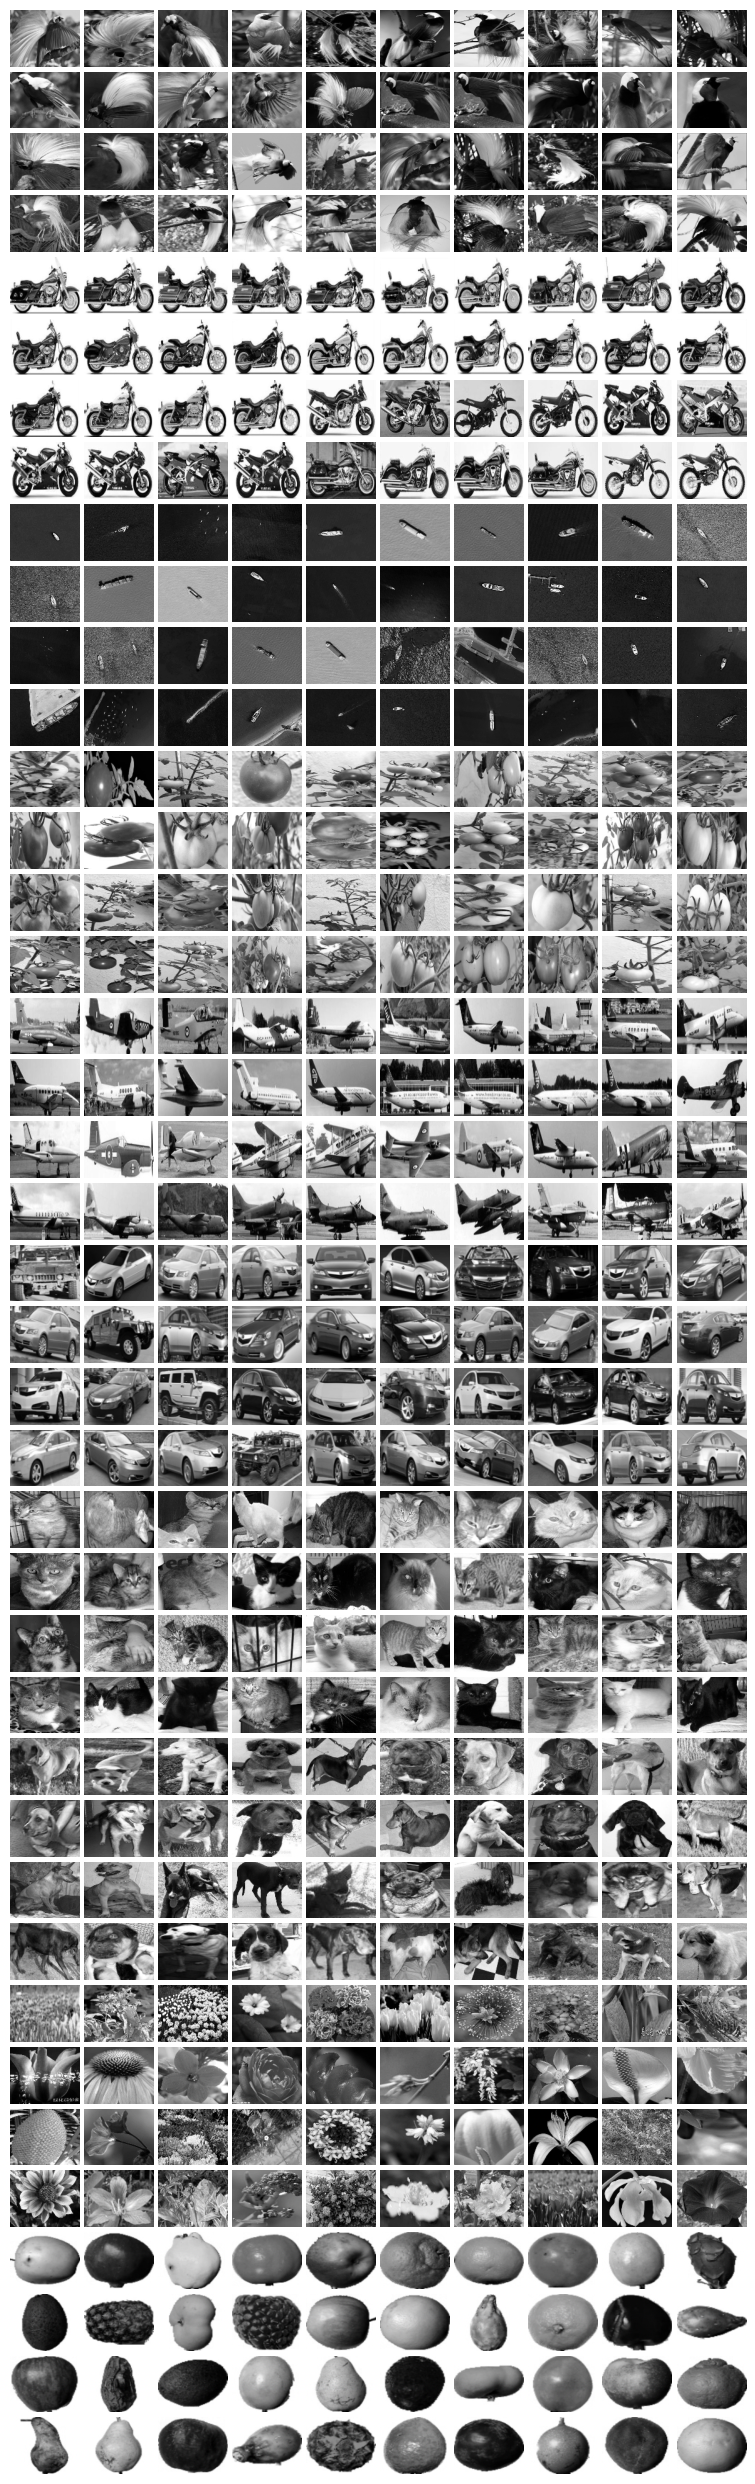

time: 2min 55s (started: 2023-03-22 22:42:36 +02:00)


In [34]:
display_images(D_non, 92, 112)

**Merging Faces and Non-faces**

In [35]:
D_mixed = np.concatenate((D[0:400,:],D_non[0:400,:]), axis=0)
np.place(y1, y>0, [0])
np.place(y2, y_non>0, [1])
y1 = y1.astype('uint8')
y2 = y2.astype('uint8')
y_mixed = np.concatenate((y1[0:400,:],y2[0:400,:]), axis=0)

time: 16 ms (started: 2023-03-22 22:45:32 +02:00)


**Splitting mixed dataset**

In [36]:
x_mixed_train = D_mixed[1::2]
x_mixed_test = D_mixed[0::2]
y_mixed_train = y_mixed[1::2]
y_mixed_test = y_mixed[0::2]

time: 0 ns (started: 2023-03-22 22:45:32 +02:00)


In [37]:
x_mixed_train.shape

(400, 10304)

time: 0 ns (started: 2023-03-22 22:45:32 +02:00)


In [38]:
y_mixed_train.shape

(400, 1)

time: 16 ms (started: 2023-03-22 22:45:32 +02:00)


In [39]:
x_mixed_test.shape

(400, 10304)

time: 16 ms (started: 2023-03-22 22:45:32 +02:00)


In [40]:
y_mixed_test.shape

(400, 1)

time: 16 ms (started: 2023-03-22 22:45:32 +02:00)


### i. Show failure and success cases

In [41]:
def compare_faces_non_faces(D_train, y_train, D_test, y_test, flag, acc_scores_list):
    knn = KNeighborsClassifier(n_neighbors=1)   
    knn.fit(D_train, np.ravel(y_train))
    y_mixed_pred = knn.predict(D_test)
    acc_score = knn.score(D_test, y_test)
    if flag == "PCA":
        acc_scores_list.append(acc_score)
        print(f"@ α = {a}:\taccuracy score = {acc_score*100}%")
    cm = confusion_matrix(y_test,y_mixed_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    print(classification_report(y_test, y_mixed_pred))
    disp.plot()
    plt.show()
    
    false_preds = np.where(np.squeeze(y_test) != np.squeeze(y_mixed_pred))
    
    return false_preds

time: 16 ms (started: 2023-03-22 22:45:32 +02:00)


#### PCA compare

In [43]:
lambdas_mix, U_mix = extract_eigs(x_mixed_train)

time: 12min 30s (started: 2023-03-22 22:45:32 +02:00)


@ α = 0.7999999999999998:	accuracy score = 99.25%
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       200
           1       1.00      0.98      0.99       200

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



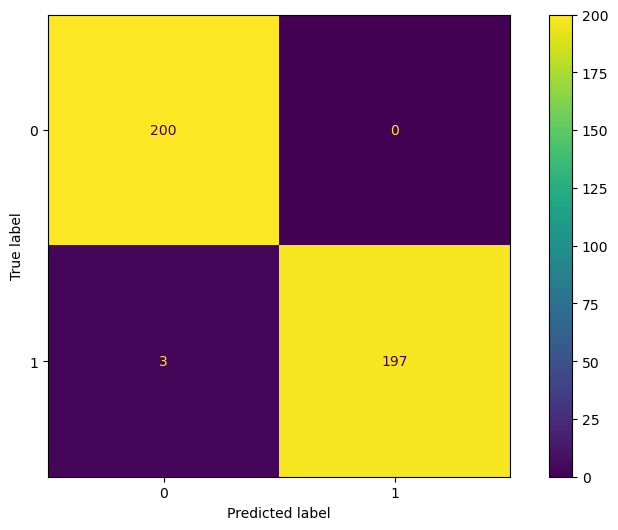

@ α = 0.8499999999999999:	accuracy score = 99.5%
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       1.00      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



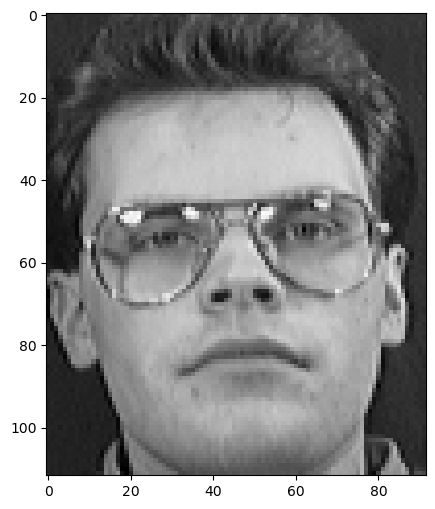

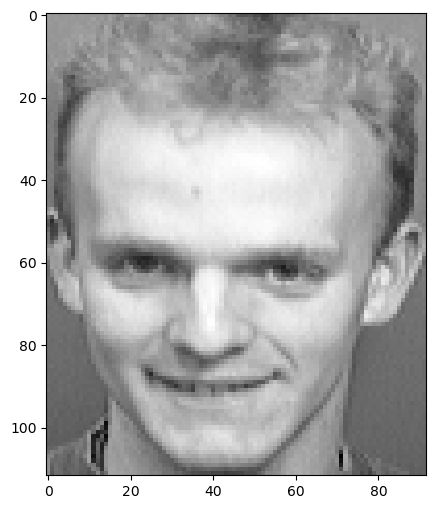

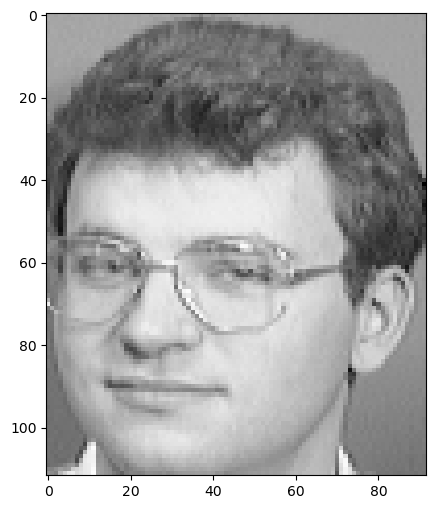

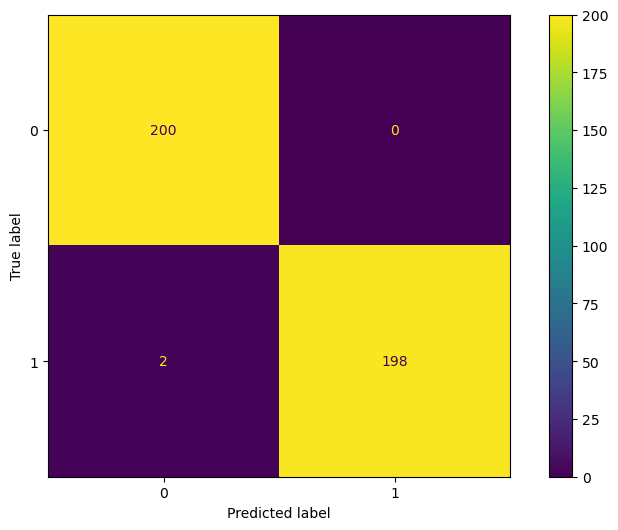

@ α = 0.8999999999999999:	accuracy score = 99.5%
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       200
           1       1.00      0.99      0.99       200

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400



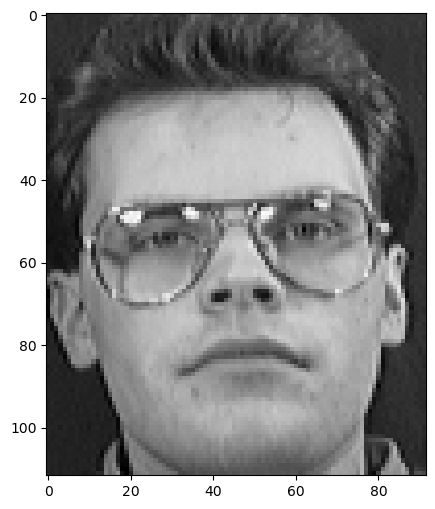

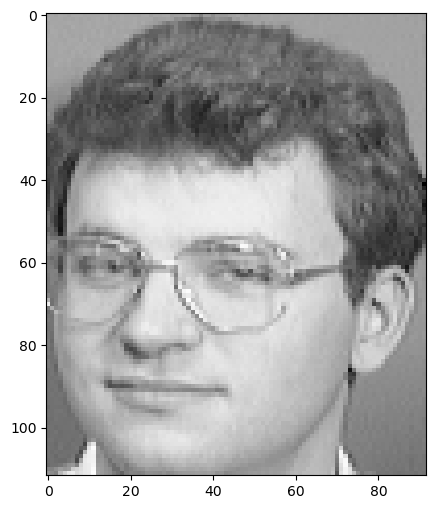

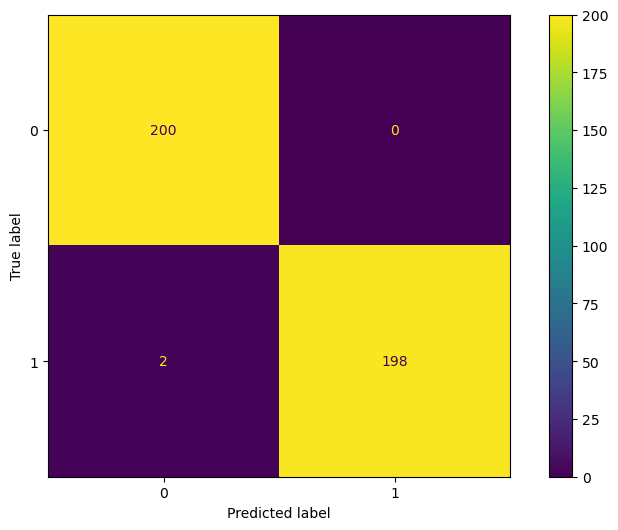

@ α = 0.95:	accuracy score = 98.0%
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       200
           1       1.00      0.96      0.98       200

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400



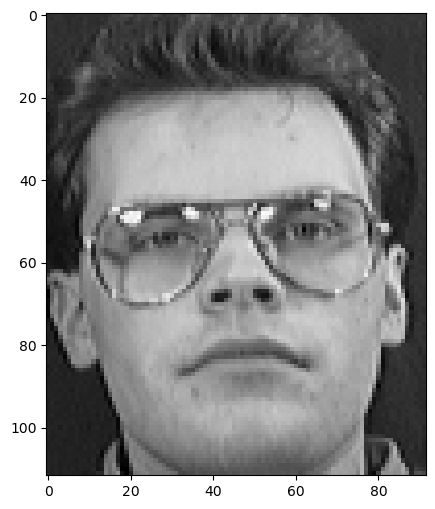

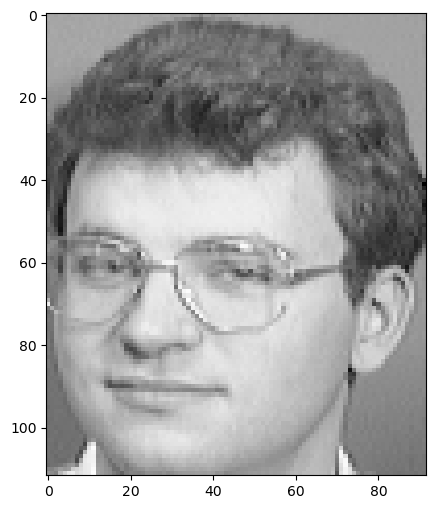

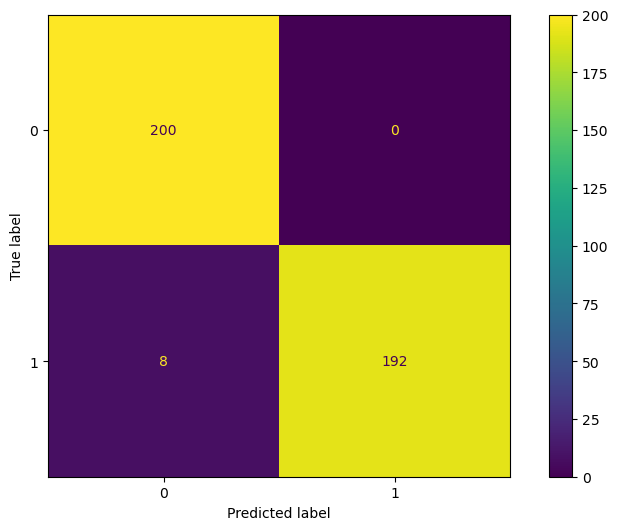

Text(0, 0.5, 'Accuracy Score')

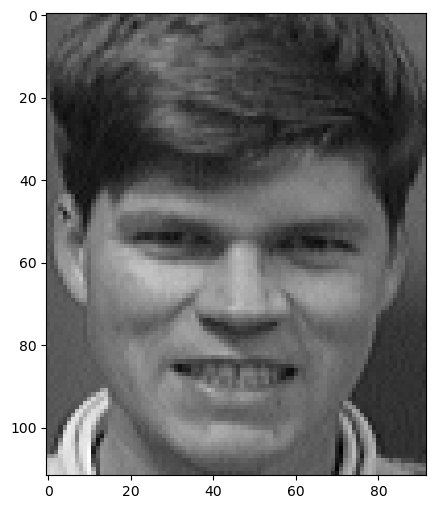

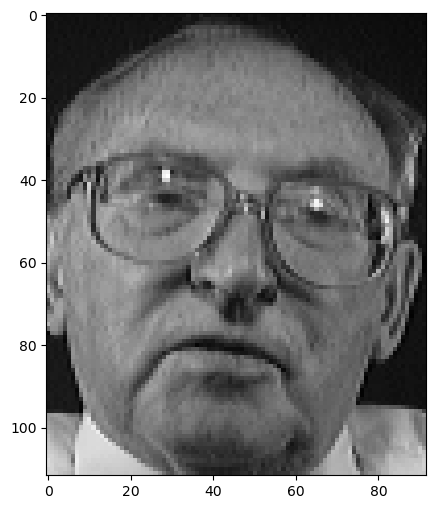

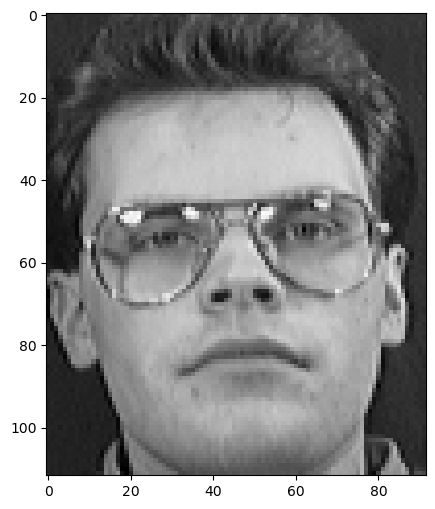

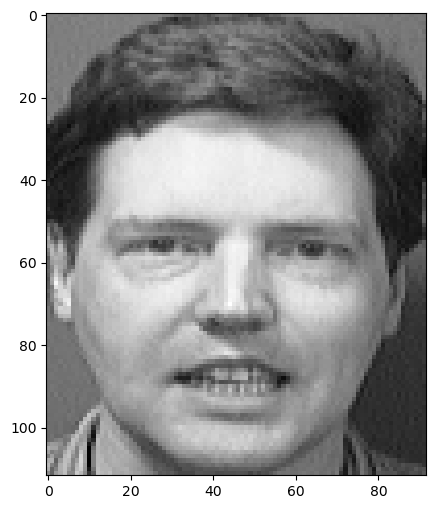

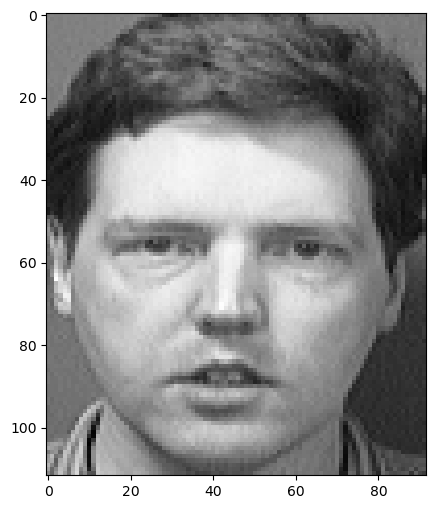

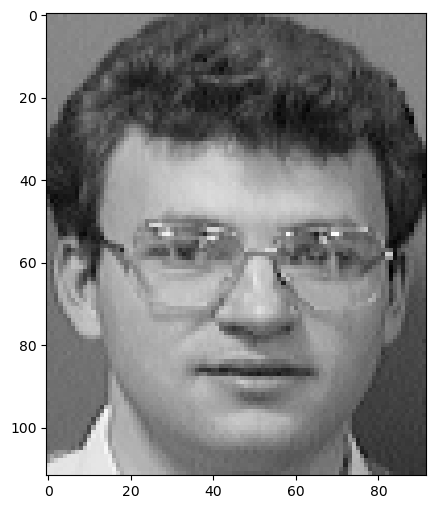

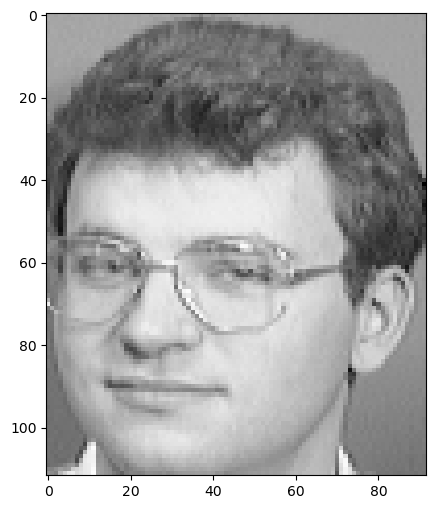

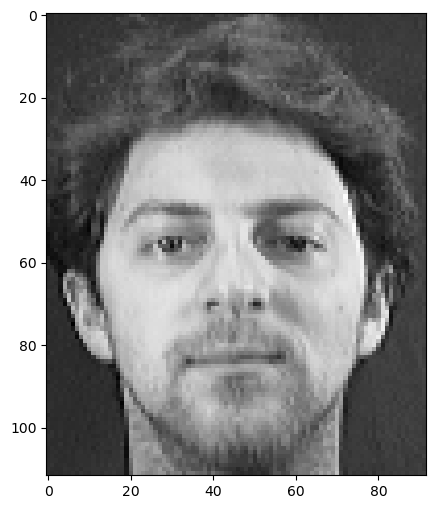

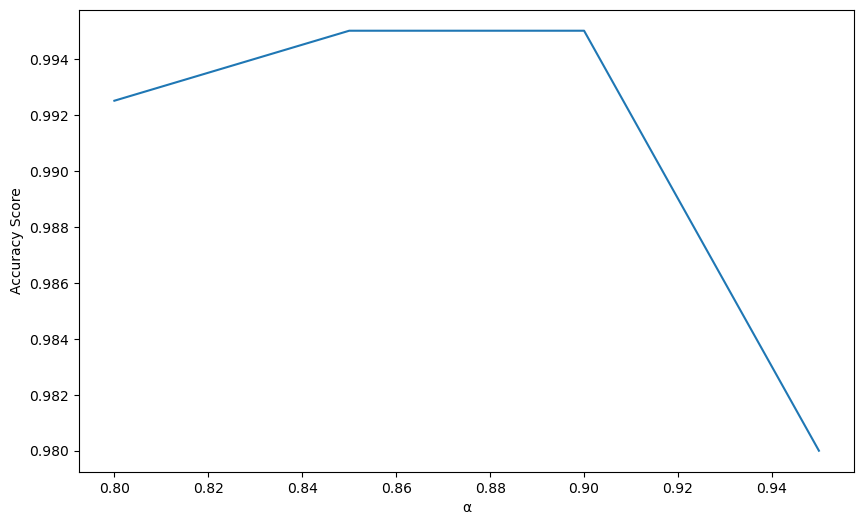

time: 18.1 s (started: 2023-03-22 22:58:02 +02:00)


In [44]:
alpha = np.arange(0.3, 1.05, 0.05)
results1 = dict()
acc_scores_list1 = []
for a in alpha[-5:-1]:
    A_train1 = PCA(x_mixed_train, lambdas_mix, U_mix, a)
    A_test1 = PCA(x_mixed_test, lambdas_mix, U_mix, a)
    results1[a] = dict()
    results1[a]['A_train'] = A_train1
    results1[a]['A_test'] = A_test1
    false_preds = compare_faces_non_faces(results1[a]['A_train'], y_mixed_train, results1[a]['A_test'], y_mixed_test,"PCA", acc_scores_list1)
    for fp in false_preds[0]:
        plt.figure()
        plt.imshow(D_mixed[fp].reshape((112, 92)), cmap='gray')
plt.figure()
plt.plot(alpha[-5:-1], acc_scores_list1)
plt.xlabel("α")
plt.ylabel("Accuracy Score")   

#### LDA compare

In [45]:
lda_mix = LDA(x_mixed_train,y_mixed_train, 1)

time: 11min 6s (started: 2023-03-22 22:58:20 +02:00)


              precision    recall  f1-score   support

           0       0.83      0.84      0.84       200
           1       0.84      0.82      0.83       200

    accuracy                           0.83       400
   macro avg       0.84      0.83      0.83       400
weighted avg       0.84      0.83      0.83       400



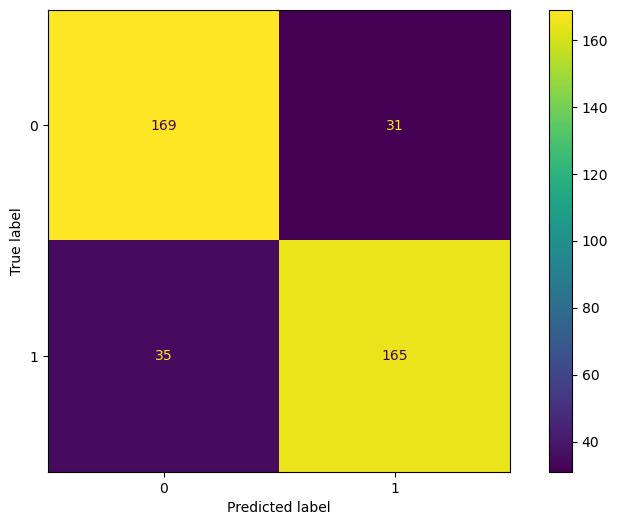

C:\Users\user\AppData\Local\Temp\ipykernel_19004\1126945041.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


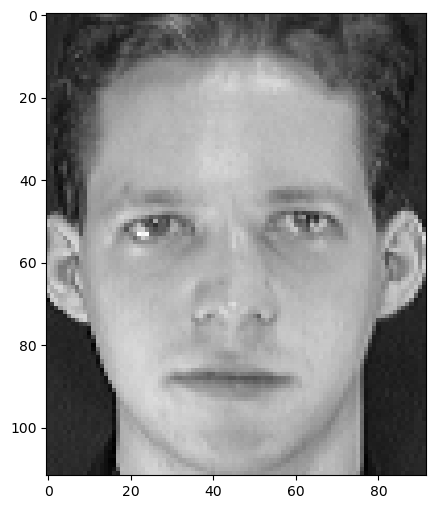

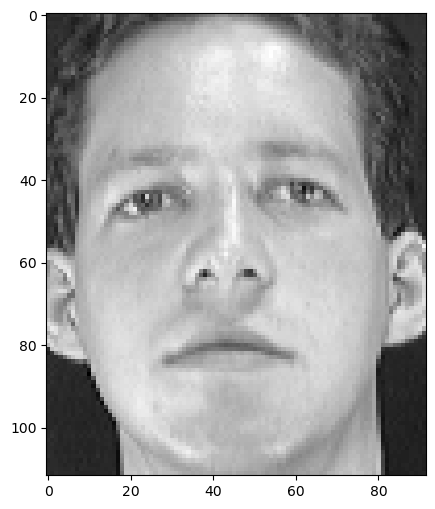

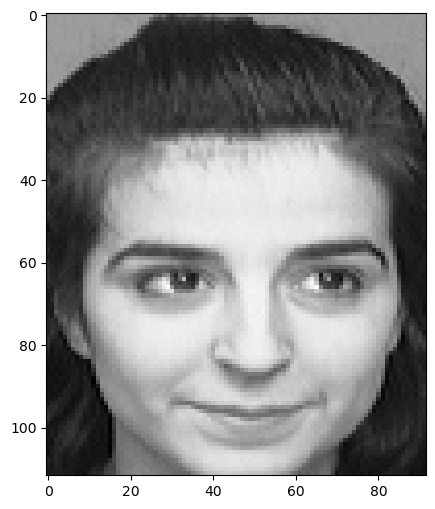

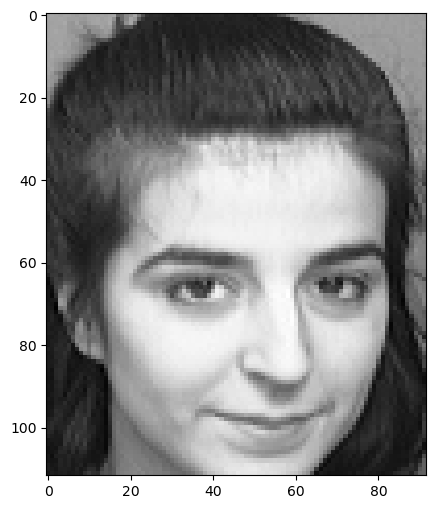

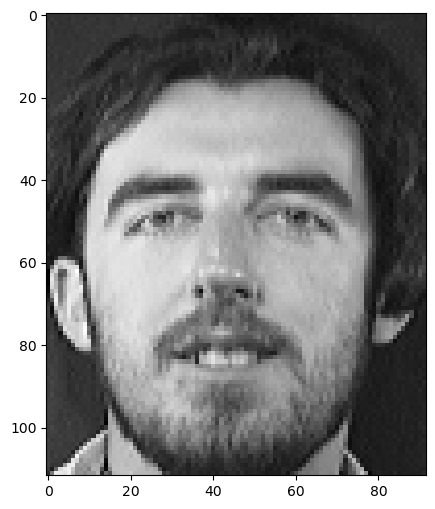

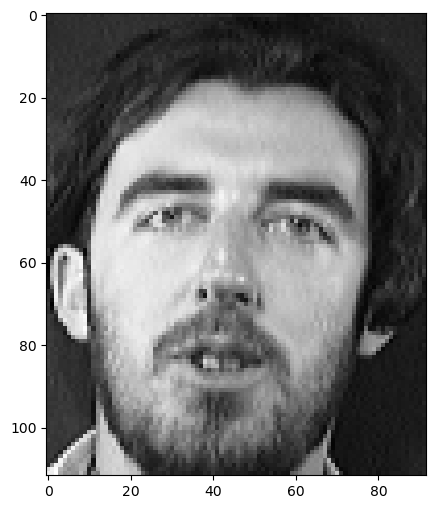

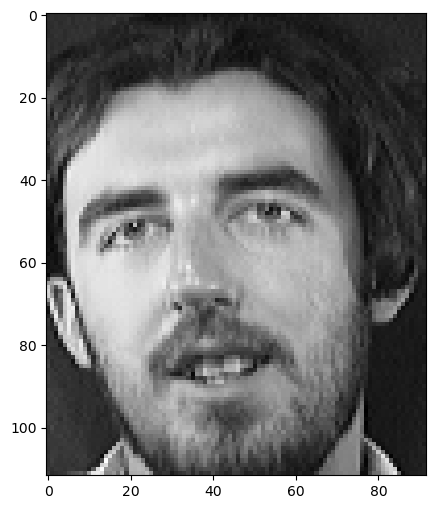

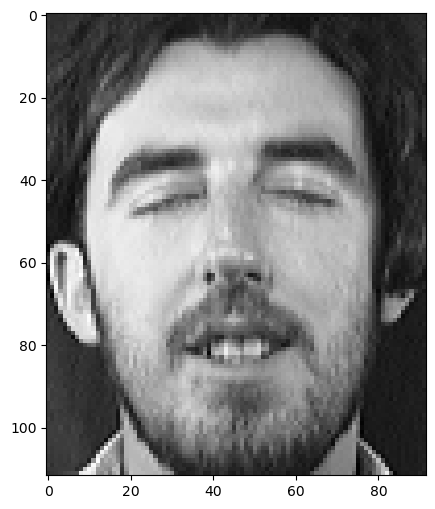

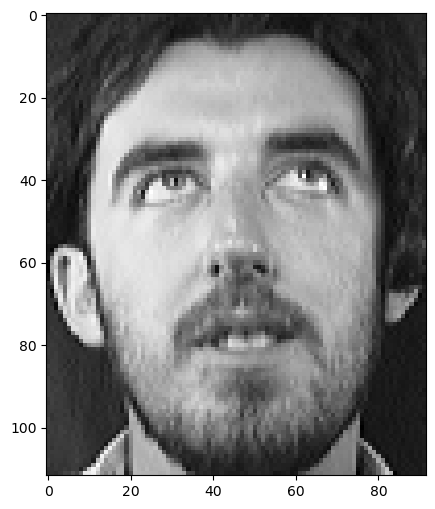

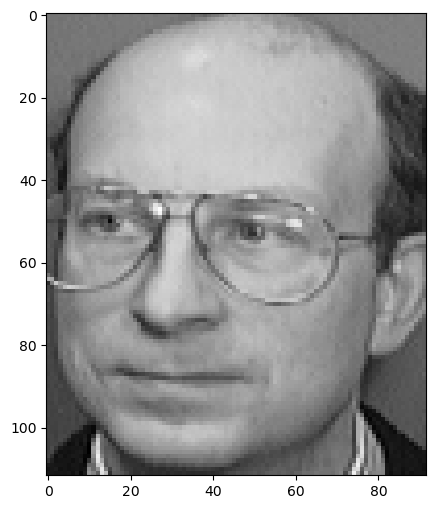

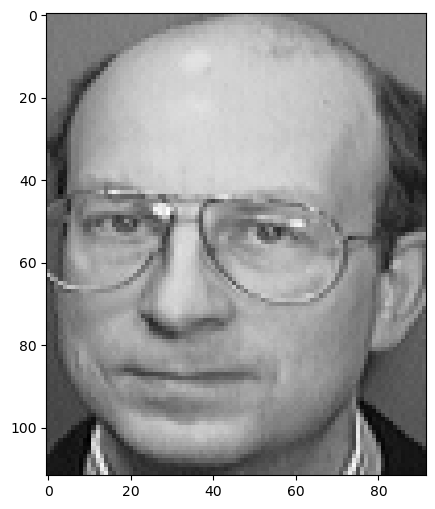

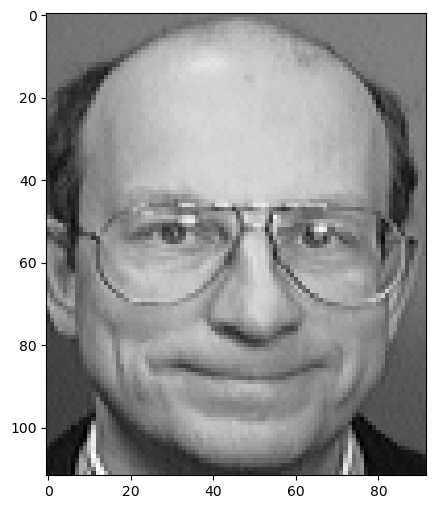

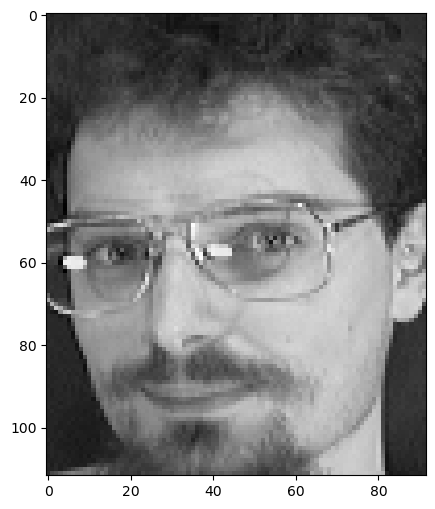

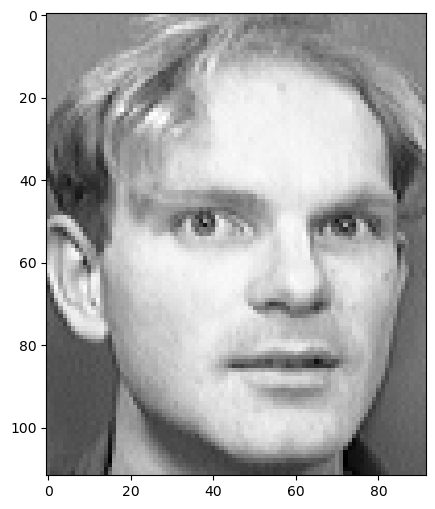

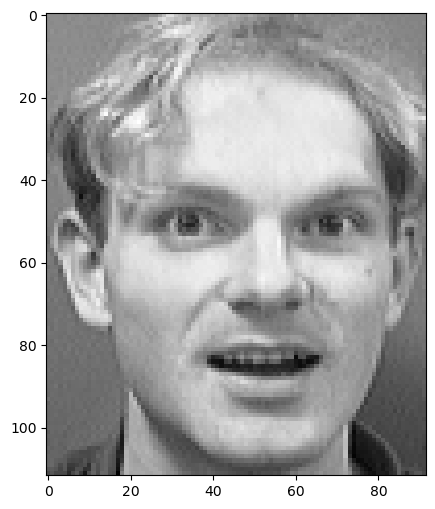

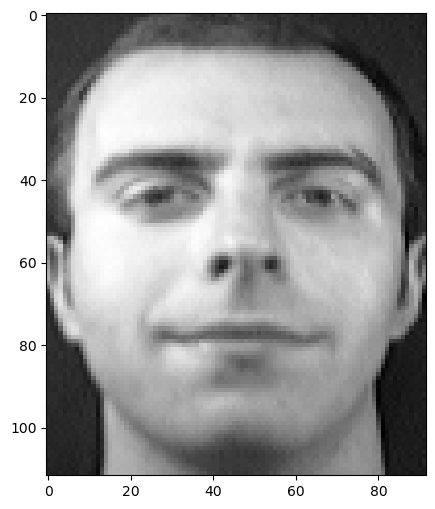

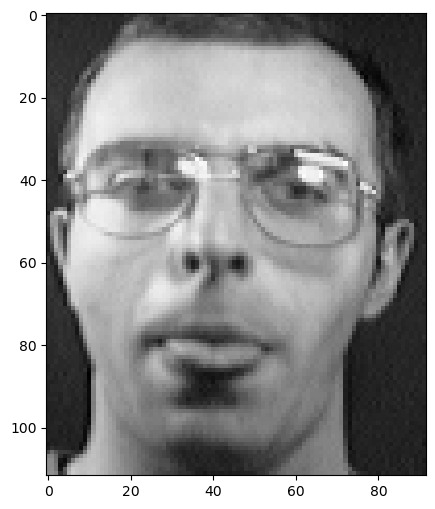

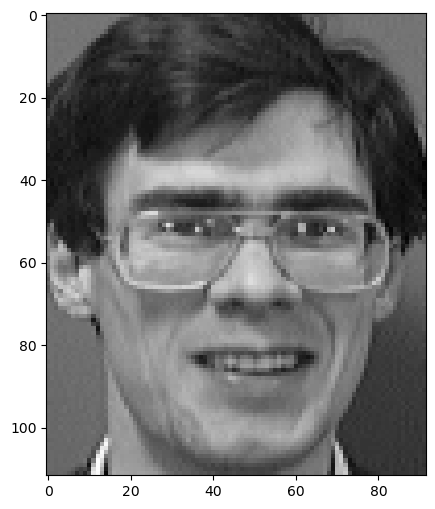

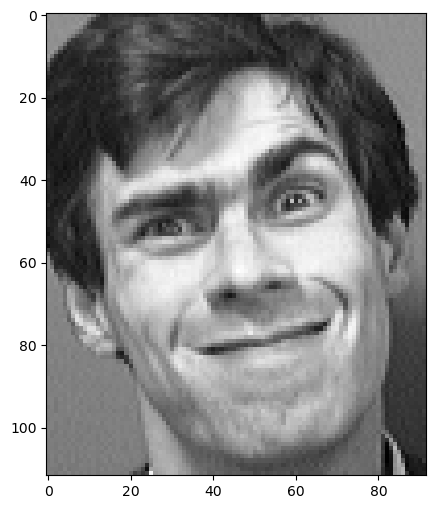

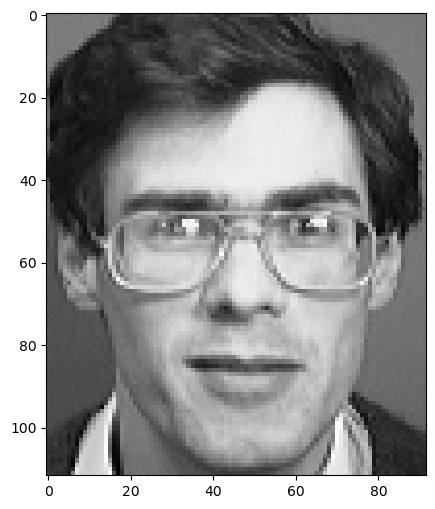

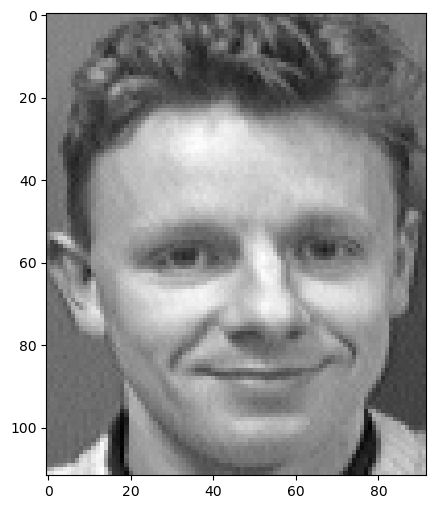

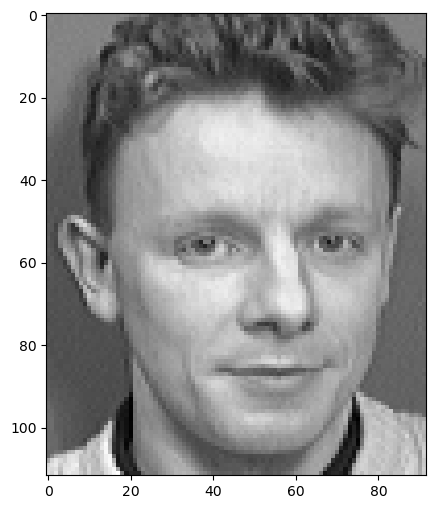

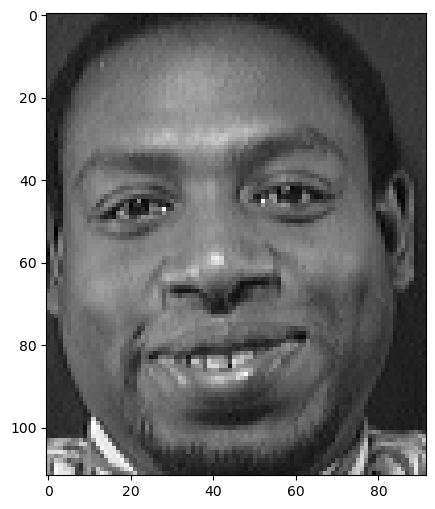

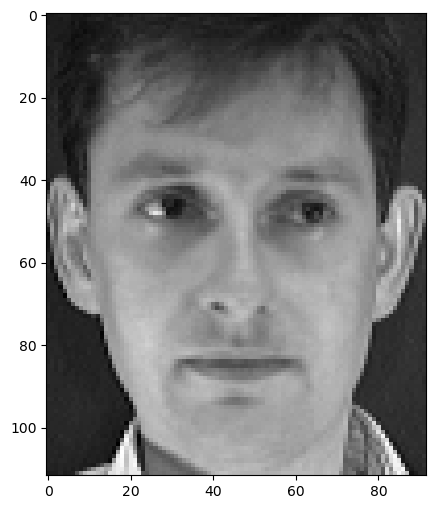

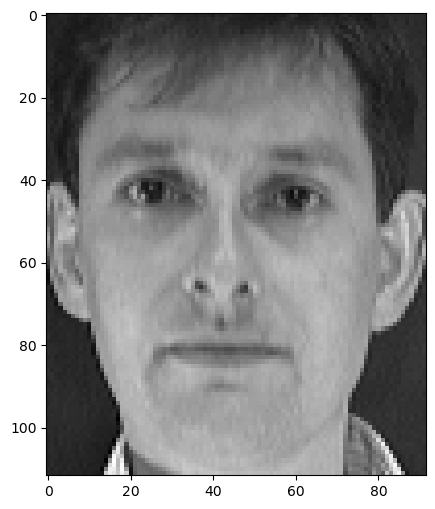

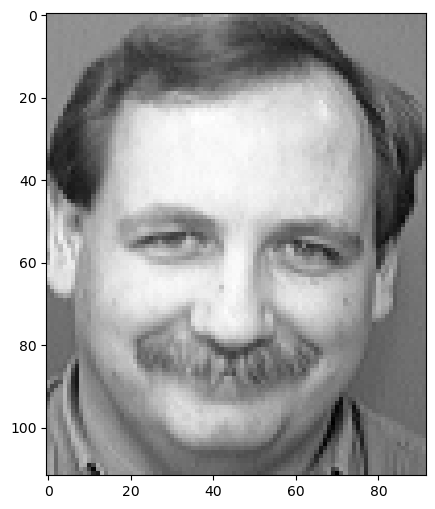

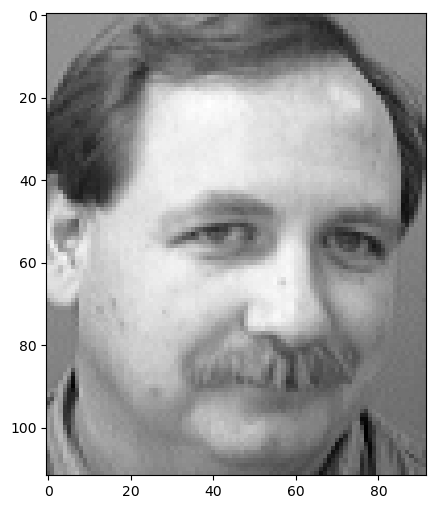

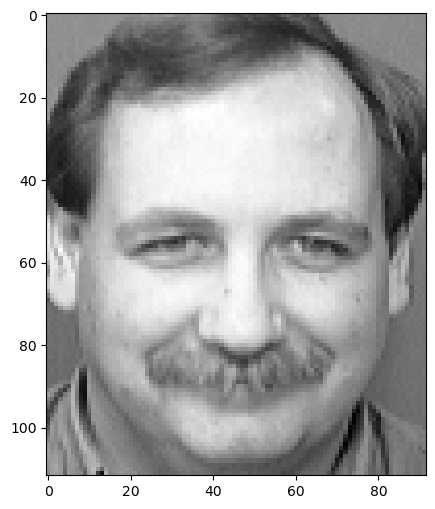

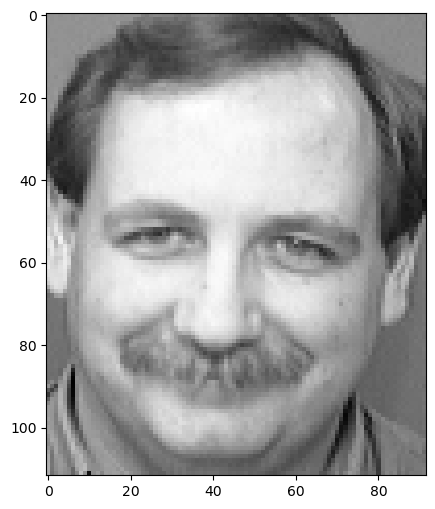

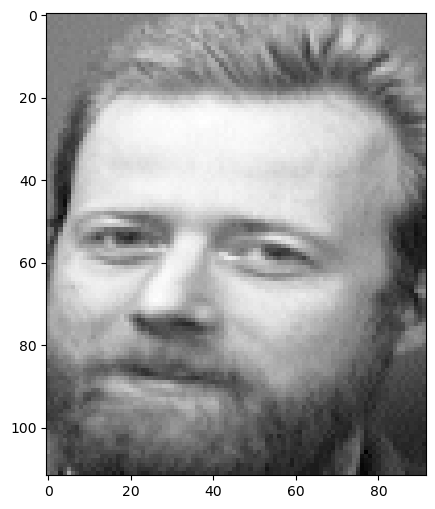

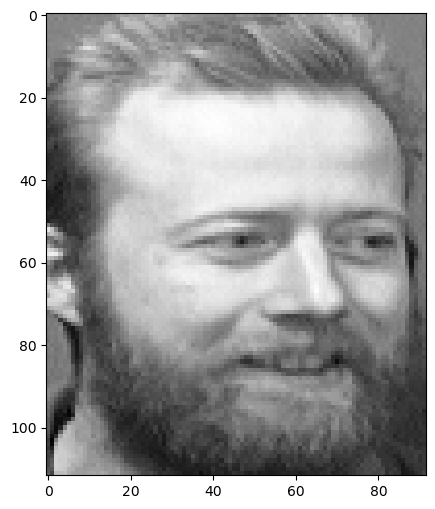

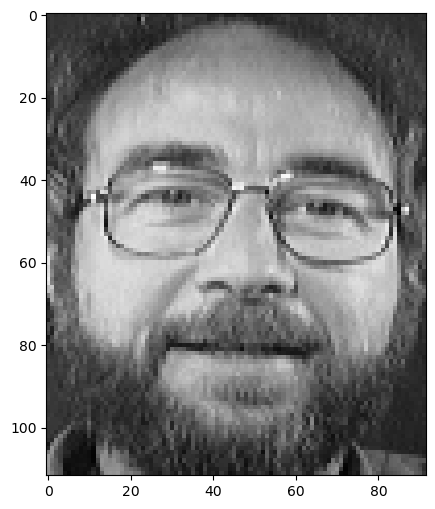

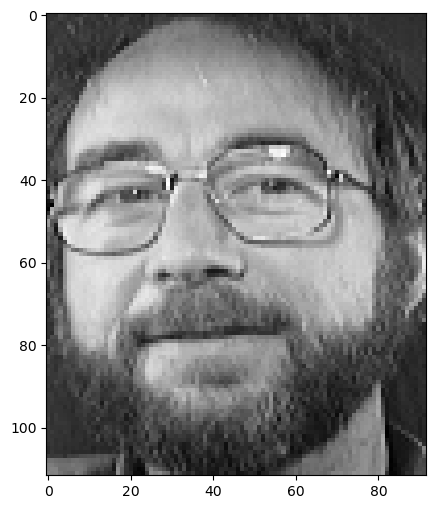

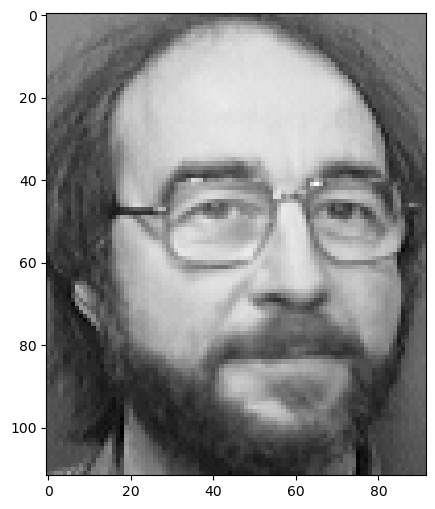

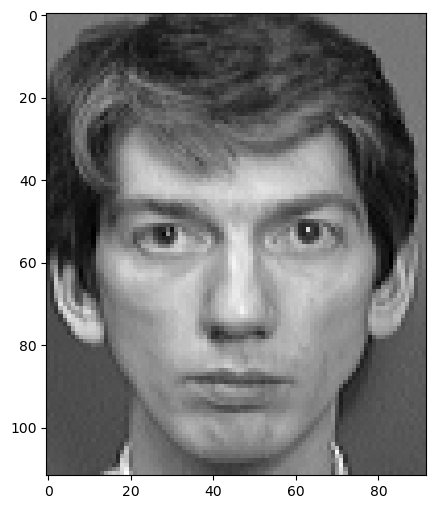

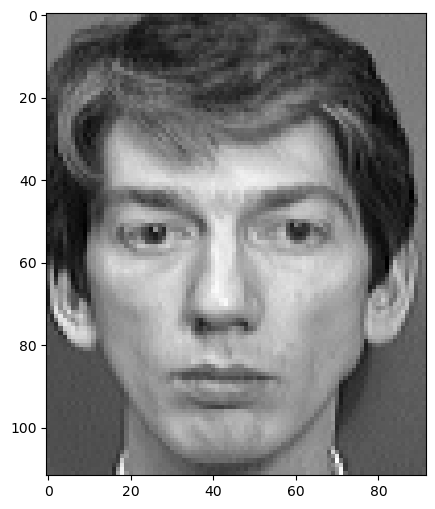

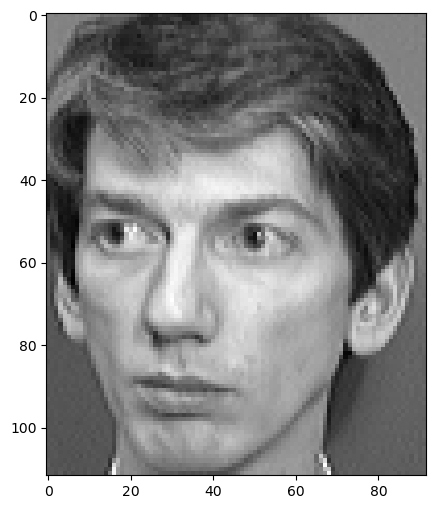

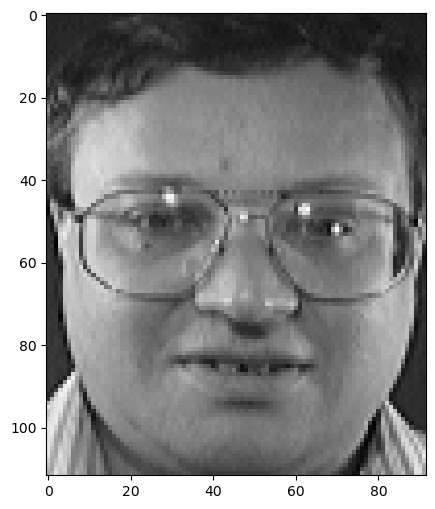

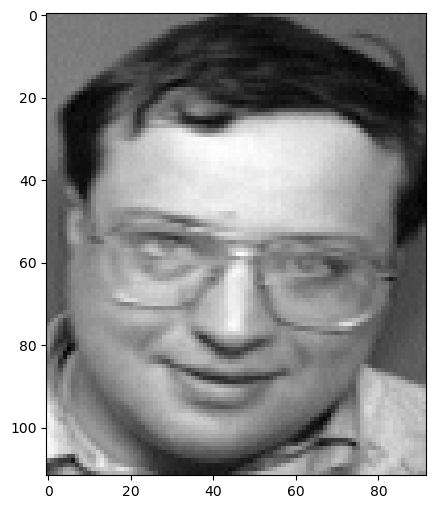

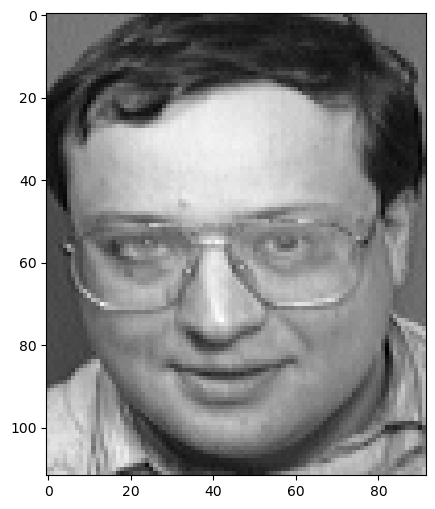

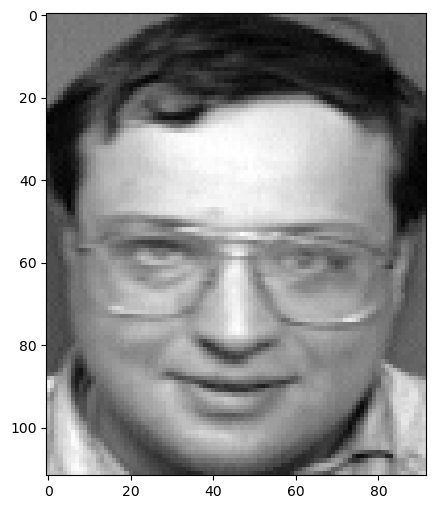

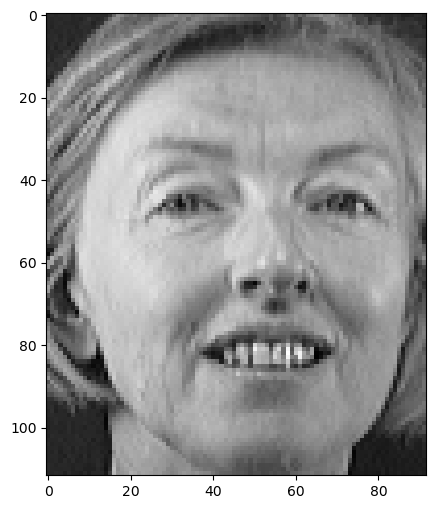

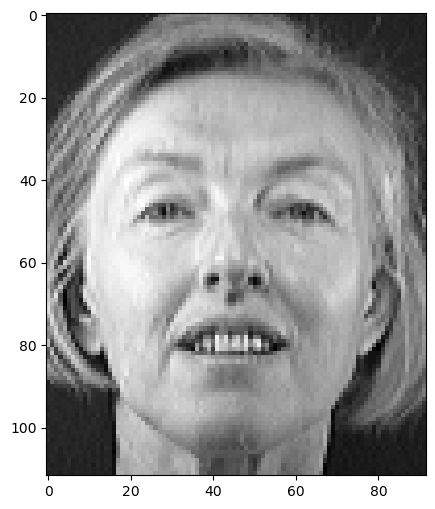

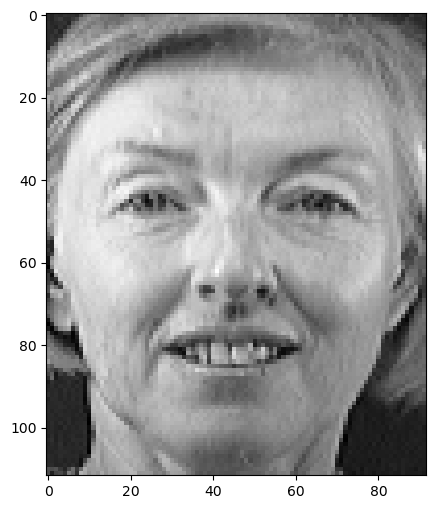

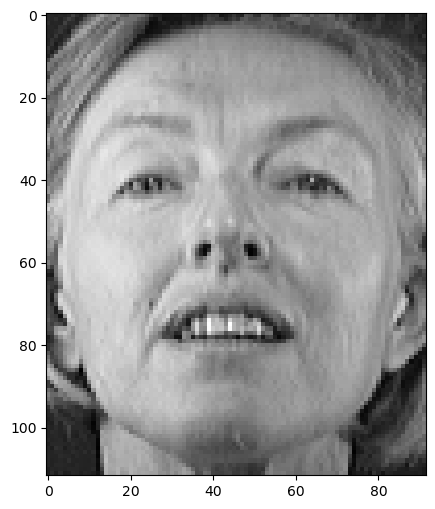

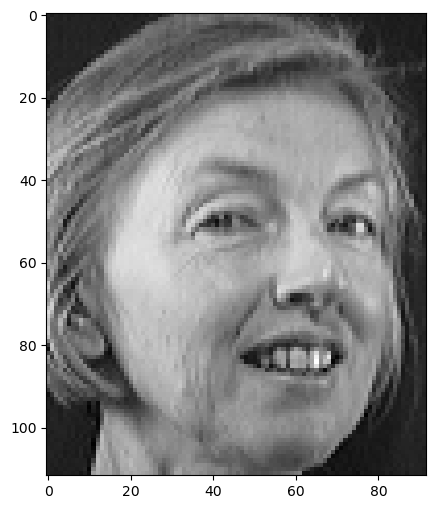

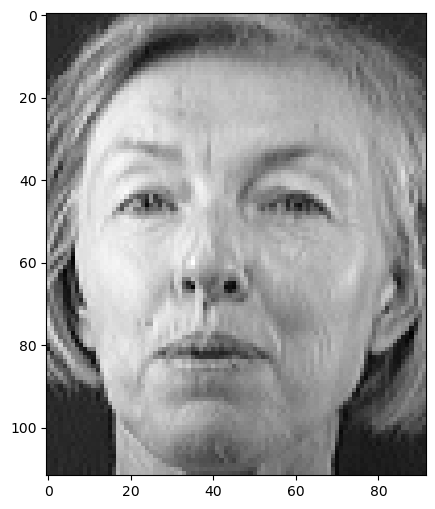

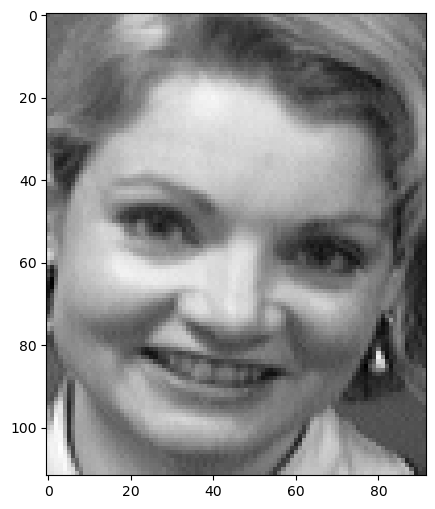

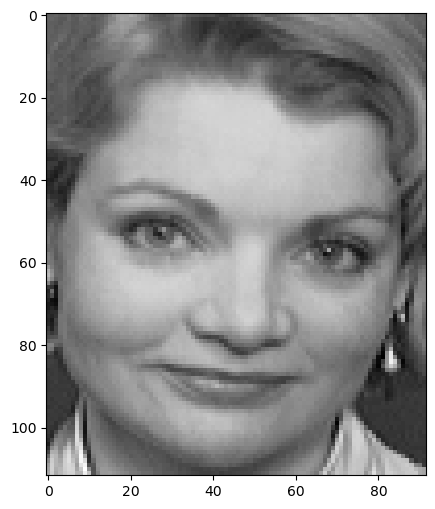

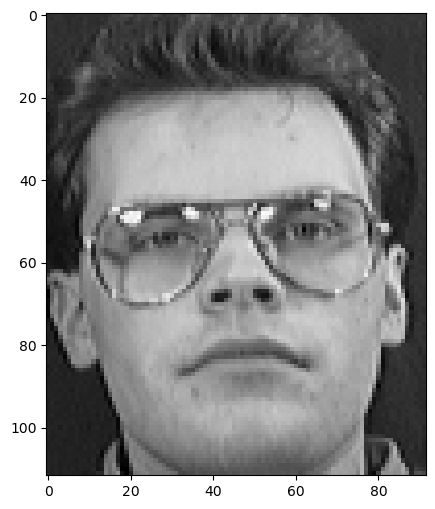

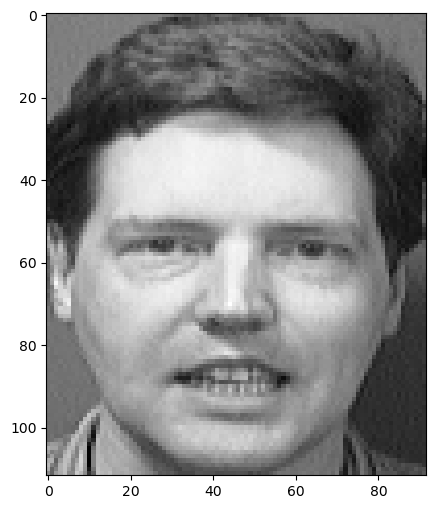

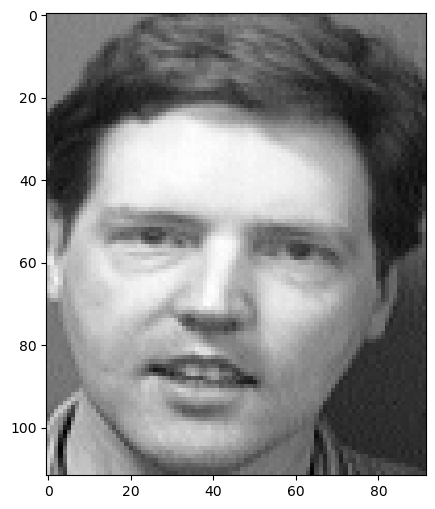

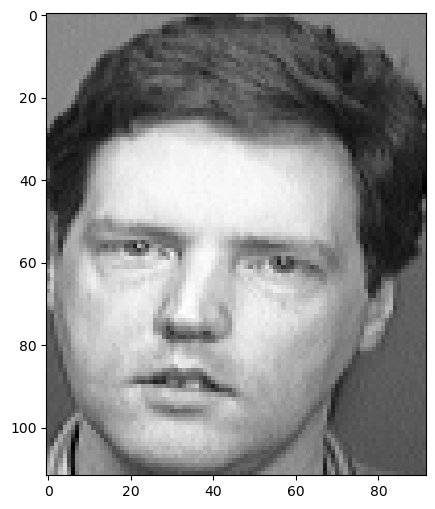

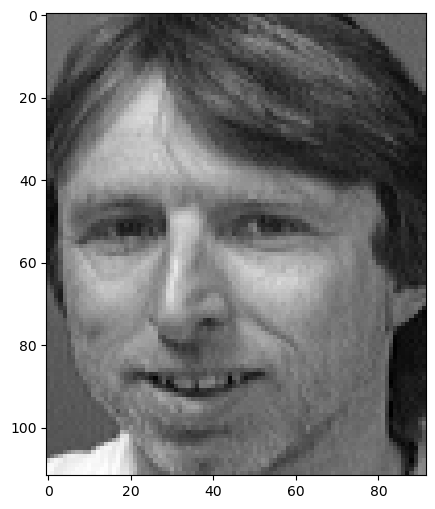

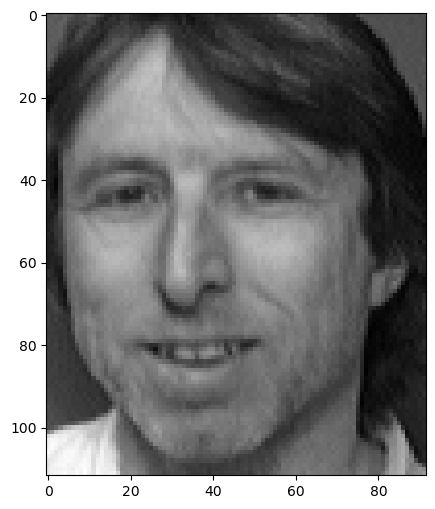

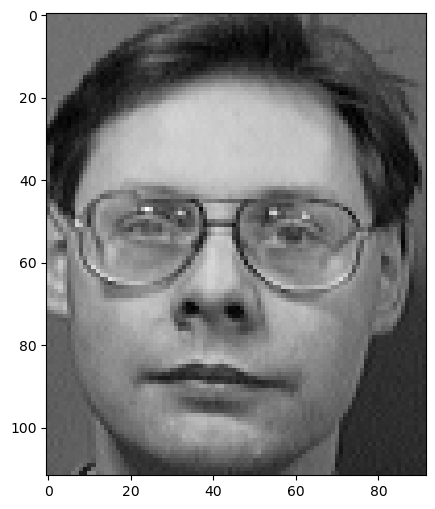

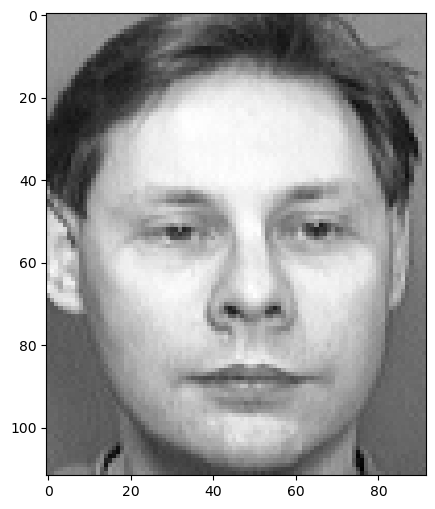

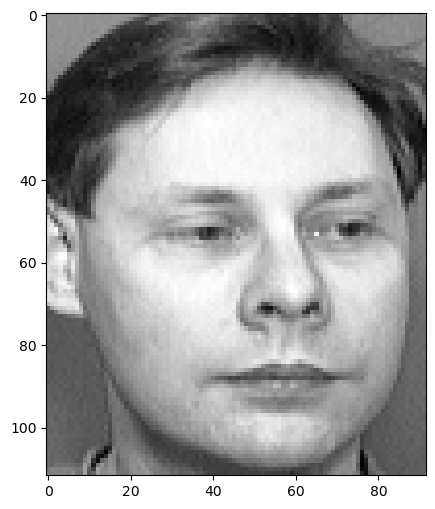

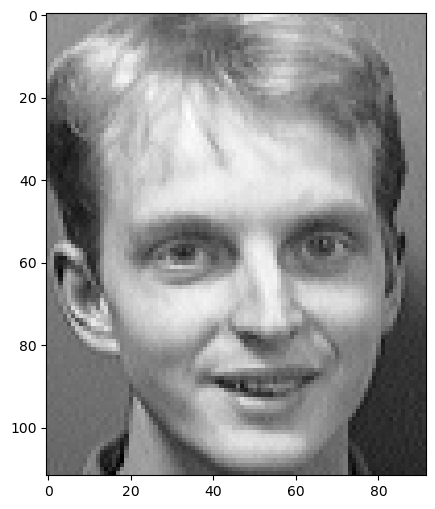

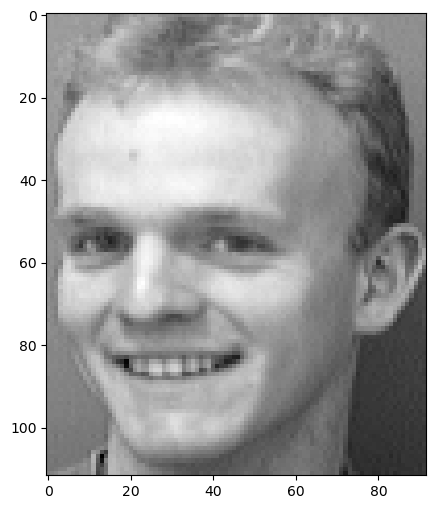

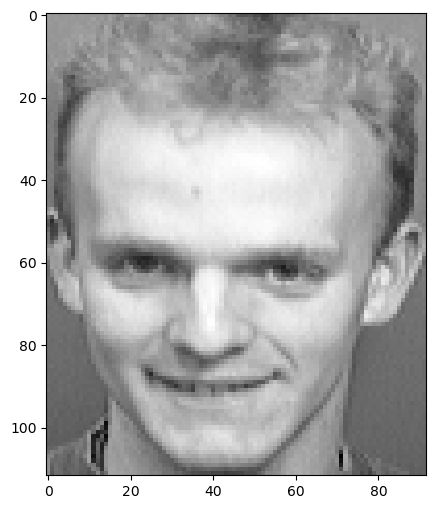

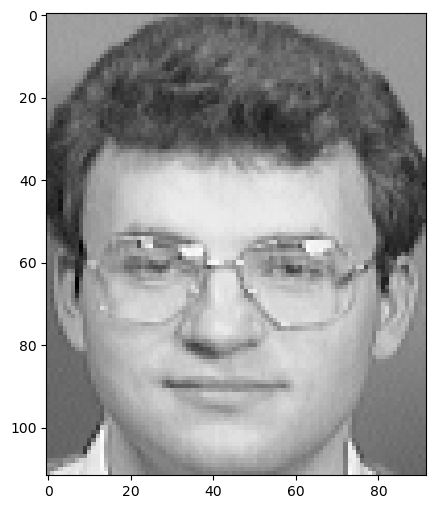

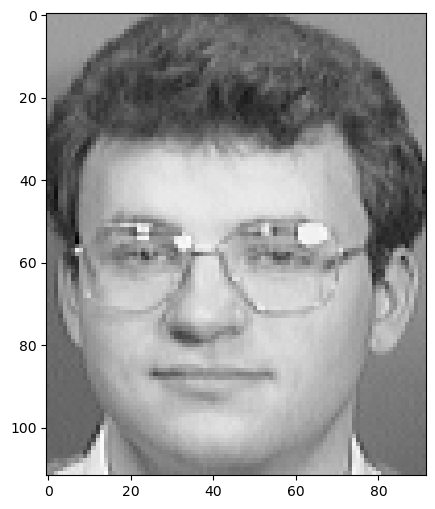

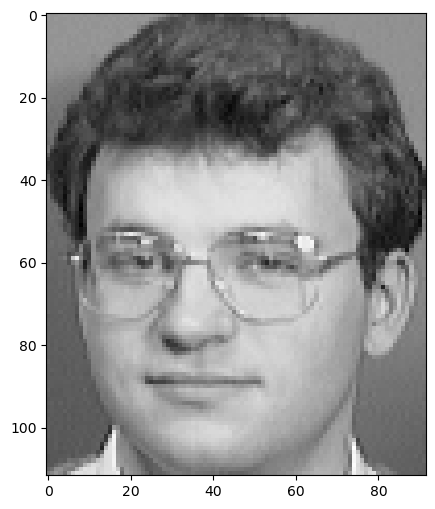

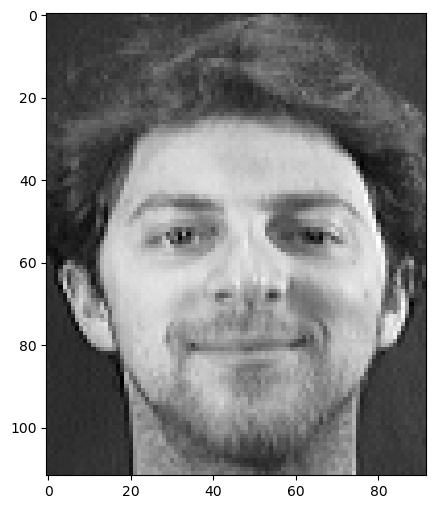

time: 22 s (started: 2023-03-22 23:09:27 +02:00)


In [46]:
lda_mix_train = x_mixed_train.dot(lda_mix)
lda_mix_test = x_mixed_test.dot(lda_mix)
false_preds = compare_faces_non_faces(lda_mix_train, y_mixed_train, lda_mix_test, y_mixed_test, flag=None, acc_scores_list=None)
for fp in false_preds[0]:
    plt.figure()
    plt.imshow(D_mixed[fp].reshape((112, 92)), cmap='gray')
plt.close()

### iii. Plot the accuracy vs the number of non-faces images while fixing the number of face images.

#### PCA

**Changing the number of non-faces before running the analysis algorithm**

@ Non-face training set size = 25:	accuracy score = 73.0%
@ Non-face training set size = 50:	accuracy score = 87.0%
@ Non-face training set size = 75:	accuracy score = 93.0%
@ Non-face training set size = 100:	accuracy score = 95.0%


Text(0, 0.5, 'Accuracy Score')

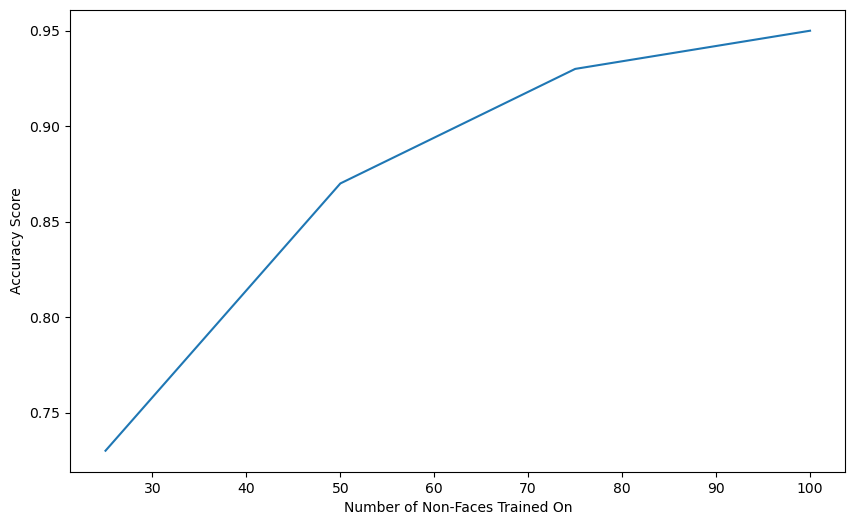

time: 29min 41s (started: 2023-03-22 23:09:49 +02:00)


In [47]:
non_face_sizes = []
acc_scores_list_nf = []
for i in range(25, 125, 25):
    lambdas_mix, U_mix = extract_eigs(x_mixed_train[:y_train.shape[0] + i, :])
    a = 0.8
    A_train = PCA(x_mixed_train[:y_train.shape[0] + i, :], lambdas_mix, U_mix, a)
    A_test = PCA(x_mixed_test, lambdas_mix, U_mix, a)
    
    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(A_train, np.ravel(y_mixed_train[:y_train.shape[0] + i, :]))
    prediction = knn.predict(A_test)
    
    acc_score = accuracy_score(y_mixed_test, prediction)
    non_face_sizes.append(i)
    acc_scores_list_nf.append(acc_score)
    print(f"@ Non-face training set size = {i}:\taccuracy score = {acc_score*100}%")

plt.plot(non_face_sizes, acc_scores_list_nf)
plt.xlabel("Number of Non-Faces Trained On")
plt.ylabel("Accuracy Score")  

**Changing the number of non-faces before running the classification algorithm**

In [74]:
lambdas_mix, U_mix = extract_eigs(x_mixed_train)

time: 4min 30s (started: 2023-03-23 00:59:54 +02:00)


@ alpha = 0.7999999999999998:
@ Non-face training set size = 25:	accuracy score = 71.0%
@ Non-face training set size = 50:	accuracy score = 85.0%
@ Non-face training set size = 75:	accuracy score = 92.0%
@ Non-face training set size = 100:	accuracy score = 95.0%

@ alpha = 0.8499999999999999:
@ Non-face training set size = 25:	accuracy score = 70.5%
@ Non-face training set size = 50:	accuracy score = 85.5%
@ Non-face training set size = 75:	accuracy score = 91.75%
@ Non-face training set size = 100:	accuracy score = 94.25%

@ alpha = 0.8999999999999999:
@ Non-face training set size = 25:	accuracy score = 69.5%
@ Non-face training set size = 50:	accuracy score = 86.0%
@ Non-face training set size = 75:	accuracy score = 91.25%
@ Non-face training set size = 100:	accuracy score = 94.25%

@ alpha = 0.95:
@ Non-face training set size = 25:	accuracy score = 67.0%
@ Non-face training set size = 50:	accuracy score = 85.5%
@ Non-face training set size = 75:	accuracy score = 89.5%
@ Non-face tra

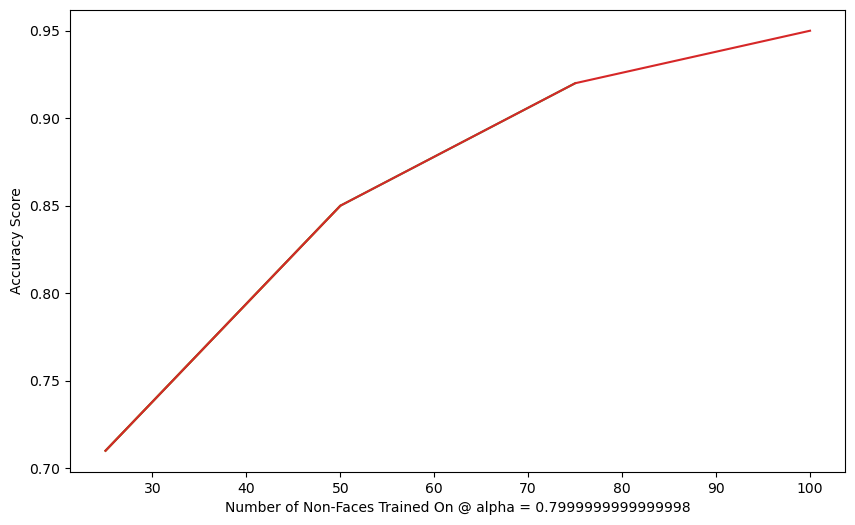

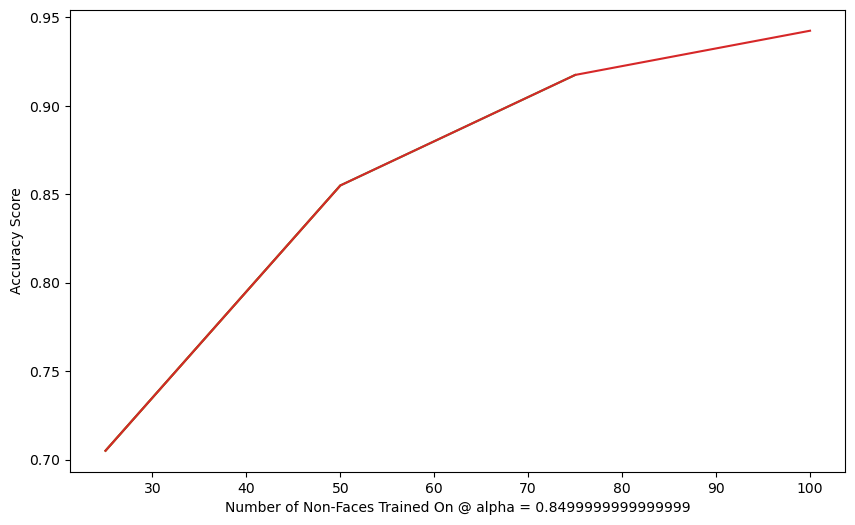

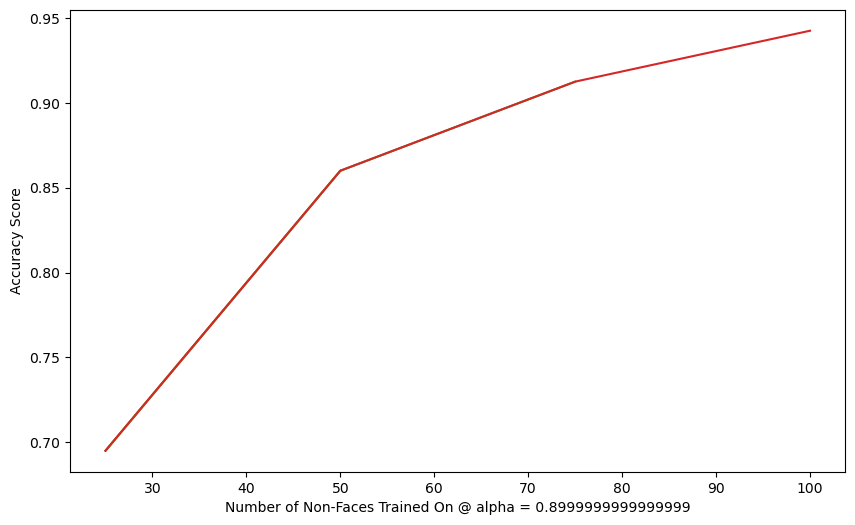

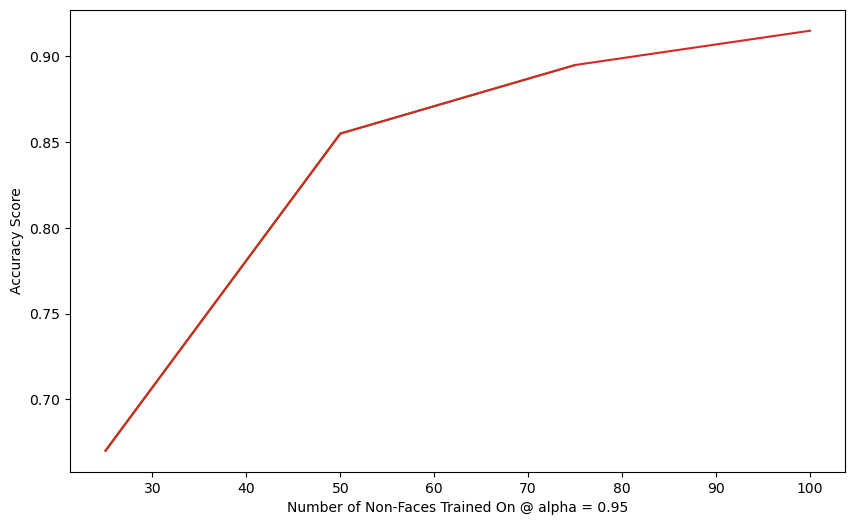

time: 3.69 s (started: 2023-03-23 01:39:53 +02:00)


In [87]:
for a in alpha[-5:-1]:
    non_face_sizes = []
    acc_scores_list_nf = []
    plt.figure()
    print(f"@ alpha = {a}:")
    for i in range(25, 125, 25):
        A_train = PCA(x_mixed_train[:y_train.shape[0] + i, :], lambdas_mix, U_mix, a)
        A_test = PCA(x_mixed_test, lambdas_mix, U_mix, a)

        knn = KNeighborsClassifier(n_neighbors=1)
        knn.fit(A_train, np.ravel(y_mixed_train[:y_train.shape[0] + i, :]))
        prediction = knn.predict(A_test)

        acc_score = accuracy_score(y_mixed_test, prediction)
        non_face_sizes.append(i)
        acc_scores_list_nf.append(acc_score)
        print(f"@ Non-face training set size = {i}:\taccuracy score = {acc_score*100}%")
        plt.plot(non_face_sizes, acc_scores_list_nf)

    # plt.legend([f'α = {np.round(a, decimals=2)}' for a in alpha[-5:-1]])
    plt.xlabel(f"Number of Non-Faces Trained On @ alpha = {a}")
    plt.ylabel("Accuracy Score")
    print()

#### LDA

**Changing the number of non-faces before running the analysis algorithm**

@ n_neighbor = 1:	accuracy score = 86.0%
@ Non-face training set size = 25:	accuracy score = 86.0%
@ n_neighbor = 1:	accuracy score = 84.75%
@ Non-face training set size = 50:	accuracy score = 84.75%
@ n_neighbor = 1:	accuracy score = 88.5%
@ Non-face training set size = 75:	accuracy score = 88.5%
@ n_neighbor = 1:	accuracy score = 81.75%
@ Non-face training set size = 100:	accuracy score = 81.75%


Text(0, 0.5, 'Accuracy Score')

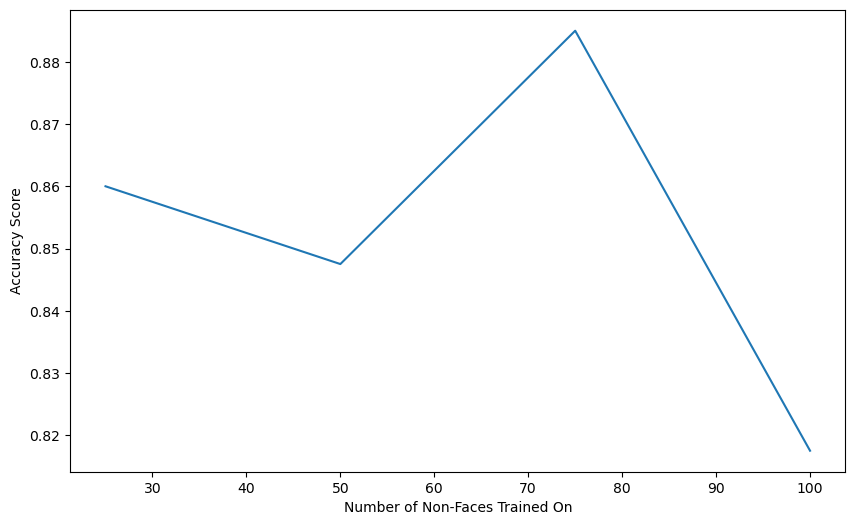

time: 34min 13s (started: 2023-03-22 23:39:31 +02:00)


In [48]:
non_face_sizes = []
acc_scores_list_nf_lda = []
for i in range(25, 125, 25):
    U_mixed_lda = LDA(x_mixed_train[:y_train.shape[0] + i, :], y_mixed_train[:y_train.shape[0] + i, :], 1)
    
    lda_mixed_train = x_mixed_train[:y_train.shape[0] + i, :].dot(U_mixed_lda)
    lda_mixed_test = x_mixed_test.dot(U_mixed_lda)
    acc_list = []
    pred = knn_classifier(None, 1, lda_mixed_train, y_mixed_train[:y_train.shape[0] + i, :], lda_mixed_test, y_mixed_test, "LDA", acc_list)
    acc_score = accuracy_score(y_mixed_test, pred)
    non_face_sizes.append(i)
    acc_scores_list_nf_lda.append(acc_score)

    print(f"@ Non-face training set size = {i}:\taccuracy score = {acc_score*100}%")

plt.plot(non_face_sizes, acc_scores_list_nf_lda)
plt.xlabel("Number of Non-Faces Trained On")
plt.ylabel("Accuracy Score")  

**Changing the number of non-faces before running the classification algorithm**

In [76]:
U_mixed_lda = LDA(x_mixed_train, y_mixed_train, 1)

time: 6min 40s (started: 2023-03-23 01:04:27 +02:00)


@ n_neighbor = 1:	accuracy score = 85.5%
@ Non-face training set size = 25:	accuracy score = 85.5%
@ n_neighbor = 1:	accuracy score = 85.5%
@ Non-face training set size = 50:	accuracy score = 85.5%
@ n_neighbor = 1:	accuracy score = 87.5%
@ Non-face training set size = 75:	accuracy score = 87.5%
@ n_neighbor = 1:	accuracy score = 87.25%
@ Non-face training set size = 100:	accuracy score = 87.25%


Text(0, 0.5, 'Accuracy Score')

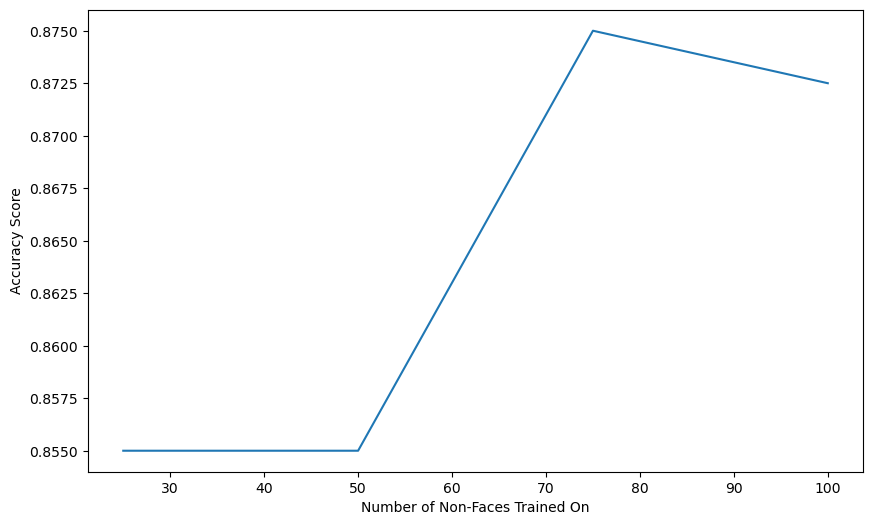

time: 594 ms (started: 2023-03-23 01:11:08 +02:00)


In [77]:
non_face_sizes = []
acc_scores_list_nf_lda2 = []
for i in range(25, 125, 25):
    lda_mixed_train = x_mixed_train[:y_train.shape[0] + i, :].dot(U_mixed_lda)
    lda_mixed_test = x_mixed_test.dot(U_mixed_lda)
    acc_list = []
    pred = knn_classifier(None, 1, lda_mixed_train, y_mixed_train[:y_train.shape[0] + i, :], lda_mixed_test, y_mixed_test, "LDA", acc_list)
    acc_score = accuracy_score(y_mixed_test, pred)
    non_face_sizes.append(i)
    acc_scores_list_nf_lda2.append(acc_score)

    print(f"@ Non-face training set size = {i}:\taccuracy score = {acc_score*100}%")

plt.plot(non_face_sizes, acc_scores_list_nf_lda2)
plt.xlabel("Number of Non-Faces Trained On")
plt.ylabel("Accuracy Score")  

## 8. Bonus


a. Use different Training and Test splits. Change the number of instances per subject to be 7 and keep 3 instances per subject for testing. Compare the results you have with the ones you got earlier with 50% split.


In [49]:
TRAIN_PERCENTAGE = 0.7
INSTANCES_PER_SUBJECT = 10
TRAIN_INSTANCES = int(TRAIN_PERCENTAGE * INSTANCES_PER_SUBJECT)
TEST_INSTANCES = int((1-TRAIN_PERCENTAGE) * INSTANCES_PER_SUBJECT)

D_divided = [D[i:i+INSTANCES_PER_SUBJECT] for i in range(0, len(D), INSTANCES_PER_SUBJECT)]
y_divided = [y[i:i+INSTANCES_PER_SUBJECT] for i in range(0, len(y), INSTANCES_PER_SUBJECT)]

x_train2 = np.array([d[:TRAIN_INSTANCES] for d in D_divided]).reshape(-1, D.shape[-1])
x_test2 = np.array([d[TRAIN_INSTANCES : TRAIN_INSTANCES + TEST_INSTANCES] for d in D_divided]).reshape(-1, D.shape[-1])
y_train2 = np.array([y[:TRAIN_INSTANCES] for y in y_divided]).reshape(-1, y.shape[-1])
y_test2 = np.array([y[TRAIN_INSTANCES : TRAIN_INSTANCES + TEST_INSTANCES] for y in y_divided]).reshape(-1, y.shape[-1])

time: 31 ms (started: 2023-03-23 00:13:44 +02:00)


In [50]:
x_train2.shape

(280, 10304)

time: 0 ns (started: 2023-03-23 00:13:44 +02:00)


In [51]:
x_test2.shape

(120, 10304)

time: 15 ms (started: 2023-03-23 00:13:44 +02:00)


In [52]:
y_train2.shape

(280, 1)

time: 0 ns (started: 2023-03-23 00:13:44 +02:00)


In [53]:
y_test2.shape

(120, 1)

time: 0 ns (started: 2023-03-23 00:13:44 +02:00)


### PCA

In [54]:
lambdas2, U2 = extract_eigs(x_train2)

time: 4min 26s (started: 2023-03-23 00:13:44 +02:00)


In [72]:
results2 = dict()
acc_scores_list2 = []
for a in alpha:
    A_train2 = PCA(x_train2, lambdas2, U2, a)
    A_test2 = PCA(x_test2, lambdas2, U2, a)
    results2[a] = dict()
    results2[a]['A_train'] = A_train2
    results2[a]['A_test'] = A_test2
    knn_classifier(a, 1, results2[a]['A_train'], y_train2, results2[a]['A_test'], y_test2, "PCA", acc_scores_list2)

@ α = 0.3:	accuracy score = 14.166666666666666%
@ α = 0.35:	accuracy score = 33.33333333333333%
@ α = 0.4:	accuracy score = 55.833333333333336%
@ α = 0.45:	accuracy score = 62.5%
@ α = 0.5:	accuracy score = 70.83333333333334%
@ α = 0.55:	accuracy score = 80.0%
@ α = 0.6:	accuracy score = 90.0%
@ α = 0.65:	accuracy score = 93.33333333333333%
@ α = 0.7:	accuracy score = 94.16666666666667%
@ α = 0.75:	accuracy score = 95.0%
@ α = 0.8:	accuracy score = 96.66666666666667%
@ α = 0.85:	accuracy score = 94.16666666666667%
@ α = 0.9:	accuracy score = 93.33333333333333%
@ α = 0.95:	accuracy score = 92.5%
@ α = 1.0:	accuracy score = 92.5%
time: 1.59 s (started: 2023-03-23 00:59:40 +02:00)


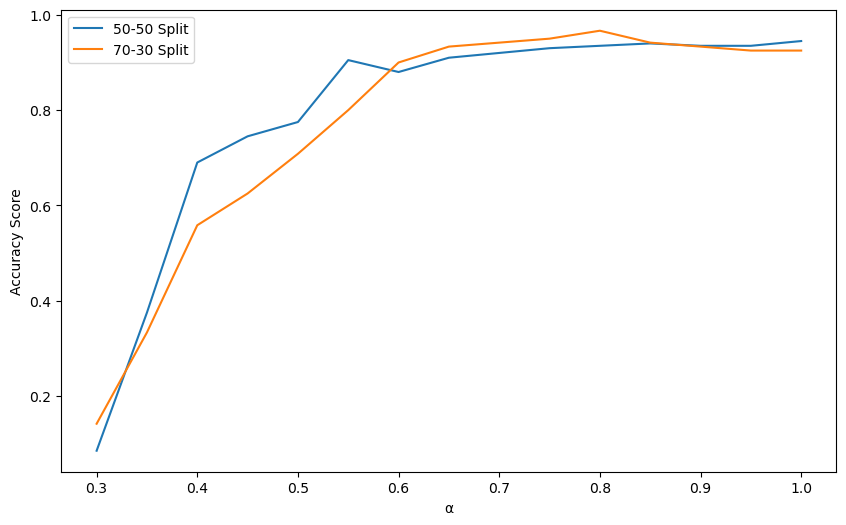

time: 187 ms (started: 2023-03-23 00:59:41 +02:00)


In [73]:
plt.plot(alpha, acc_scores_list, label='50-50 Split')
plt.plot(alpha, acc_scores_list2, label='70-30 Split')
plt.legend()
plt.xlabel("α")
plt.ylabel("Accuracy Score")
plt.show()

### LDA

In [64]:
U_lda_2 = LDA(x_train2, y_train2, 39)

time: 8min 9s (started: 2023-03-23 00:40:51 +02:00)


In [65]:
lda_train2 = x_train2.dot(U_lda_2)
lda_test2 = x_test2.dot(U_lda_2)
acc_list2=[]
pre = knn_classifier(None, 1, lda_train2, y_train2, lda_test2, y_test2, "LDA", acc_list2)

@ n_neighbor = 1:	accuracy score = 95.0%
time: 141 ms (started: 2023-03-23 00:49:01 +02:00)
